In [1]:
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()
base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")
community_cfg = config_loader.get_section(all_configs, "community")

In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}") # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8


device(type='cuda')

In [3]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor

print(base_configs)
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

{'paths': {'raw': 'data/raw/deb_label.csv', 'processed': 'data/processed'}, 'labels': {0: 'disagree', 1: 'neutral', 2: 'agree'}, 'subreddits': {'brexit': 0, 'blacklivesmatter': 1, 'climate': 2, 'democrats': 3, 'republican': 4}, 'required_columns': ['label', 'msg_id_parent', 'msg_id_child', 'submission_id', 'body_parent', 'body_child', 'submission_text', 'subreddit', 'author_parent', 'author_child', 'datetime', 'agreement_fraction', 'individual_kappa'], 'cleaning': {'normalize_subreddits': True, 'rename_columns': {'author_child': 'src_author', 'author_parent': 'dst_author', 'msg_id_child': 'src_comment_id', 'msg_id_parent': 'dst_comment_id', 'body_child': 'src_comment_text', 'body_parent': 'dst_comment_text', 'datetime': 'timestamp'}, 'timestamp_parsing': {'primary_format': '%d/%m/%Y %H:%M', 'dayfirst': True, 'error_handling': 'coerce', 'fallback_formats': ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M', '%Y-%m-%d']}, 'remove_self_replies': True}, 'temporal': {'infer_parent_comment_time': {'enab

In [4]:
# Build graphs
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
pairs = processed_data.user_pairs
comments = processed_data.comments

graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, wcc_mode=min_edges, edge_attrs=['mean_confidence', 'net_vector']
[Subreddit 0, T0] [WCC:min_edges] Nodes 32->29, Edges 86->84 (2.3% edges removed)
[Subreddit 0, T1] [WCC:min_edges] Nodes 30->30, Edges 79->79 (0.0% edges removed)
[Subreddit 0, T2] [WCC:min_edges] Nodes 31->31, Edges 59->59 (0.0% edges removed)
[Subreddit 0, T3] [WCC:min_edges] Nodes 43->43, Edges 107->107 (0.0% edges removed)
[Subreddit 0, T4] [WCC:min_edges] Nodes 53->53, Edges 134->134 (0.0% edges removed)
[Subreddit 0, T5] [WCC:min_edges] Nodes 71->71, Edges 266->266 (0.0% edges removed)
[Subreddit 0, T6] [WCC:min_edges] Nodes 79->79, Edges 187->187 (0.0% edges removed)
[Subreddit 0, T7] [WCC:min_edges] Nodes 96->94, Edges 177->176 (0.6% edges removed)
[Subreddit 0, T8] [WCC:min_edges] Nodes 187->187, Edges 611->611 (0.0% edg

c:\Users\vduch\OneDrive\ecs_msc_project\src\modules\graph_processor.py:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  x = torch.tensor(node_features, dtype=torch.float)


    + Created 77 PyG graphs
Saved PyG graphs to data/processed/pyg_graphs_384D.pt


In [5]:
# Load trained model and extract GNN node embeddings
import importlib
import src.utils.gnn_checkpointing
importlib.reload(src.utils.gnn_checkpointing)

from src.utils.gnn_checkpointing import load_model_checkpoint

ckpt_path = "checkpoints/best_model_2508152029.pth"
model_class_path = "src.models.multitask_debate_gnn.MultitaskDebateGNN"
gnn_model, gnn_ckpt = load_model_checkpoint(
    ckpt_path,
    device=device,
    model_class_path=model_class_path,
)

gnn_model.eval()
print(f"Loaded: {gnn_model.__class__.__name__}")
print(f"Checkpoint keys: {list(gnn_ckpt.keys())}")

Loading model checkpoint from checkpoints/best_model_2508152029.pth
Loaded: MultitaskDebateGNN
Checkpoint keys: ['state_dict', 'model_args', 'train_args']


In [6]:
# Import the ECS processor
from src.modules.ecs_processor import ECSProcessor, create_ecs_processor

ecs_processor = create_ecs_processor(
    base_configs=base_configs,
    community_configs=community_cfg,
    gnn_model_path="checkpoints/best_model_2508152029.pth",
    gnn_model_class_path="src.models.multitask_debate_gnn.MultitaskDebateGNN",
    device=device
)

# Process all graphs
pyg_graphs, graph_dict = graph_data.pyg_graphs, graph_data.graph_dict
processed_dict = ecs_processor.process_graphs(pyg_graphs, graph_dict)

# Get results DataFrame
ecs_df = ecs_processor.get_results_dataframe()

print(f"ECS computation complete!")
print(f"Processed {len(processed_dict)} subreddits")
print(f"Results DataFrame shape: {ecs_df.shape}")

Loading model checkpoint from checkpoints/best_model_2508152029.pth
Loaded GNN model: MultitaskDebateGNN
Starting ECS processing for 77 graphs
Processing graph for subreddit: 0, timestep: 0
  Extracted node mapping: 29 nodes
  Graph stats: 29 nodes, 84 edges
Using device: cuda
  Communities found: 3
  Community sizes (min=6): [np.int64(13), np.int64(10), np.int64(6)]
  Modularity: 0.238
  EchoGAE ECI: 0.4924 | Community ECIs: ['0.3954', '0.6624', '0.4193']
  DebateGNN ECI: 0.5192 | Community ECIs: ['0.5976', '0.4440', '0.4745']
  **Embedding-Community Alignment Analysis**
    EchoGAE Embedding-Community Alignment:
    Silhouette Score: -0.0960 (higher = better separation)
    + Avg Intra-Community Distance: 0.6872
    + Avg Inter-Community Distance: 0.7225
    + Distance Ratio (Inter/Intra): 1.0515
    DebateGNN Embedding-Community Alignment:
    Silhouette Score: -0.0516 (higher = better separation)
    + Avg Intra-Community Distance: 0.4414
    + Avg Inter-Community Distance: 0.4673


Starting complete ECS analysis with pre-computed results...
Analyzing community evolution...
Computing evolution for brexit across 23 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

--- Timestep 0 -> 1 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.448
User Retention: 72.4%

--- Timestep 1 -> 2 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.400
User Retention: 70.0%

--- Timestep 2 -> 3 ---
Communities: 2 -> 4
Total Jaccard (Hungarian): 0.310
User Retention: 74.2%

--- Timestep 3 -> 4 ---
Communities: 4 -> 4
Total Jaccard (Hungarian): 0.669
User Retention: 79.1%

--- Timestep 4 -> 5 ---
Communities: 4 -> 3
Total Jaccard (Hungarian): 0.596
User Retention: 86.8%

--- Timestep 5 -> 6 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.462
User Retention: 78.9%

--- Timestep 6 -> 7 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.344
User Retention: 75.9%

--- Timestep 7 -> 8 ---
Communities: 2 -> 6
Total Jaccard (Hungarian): 

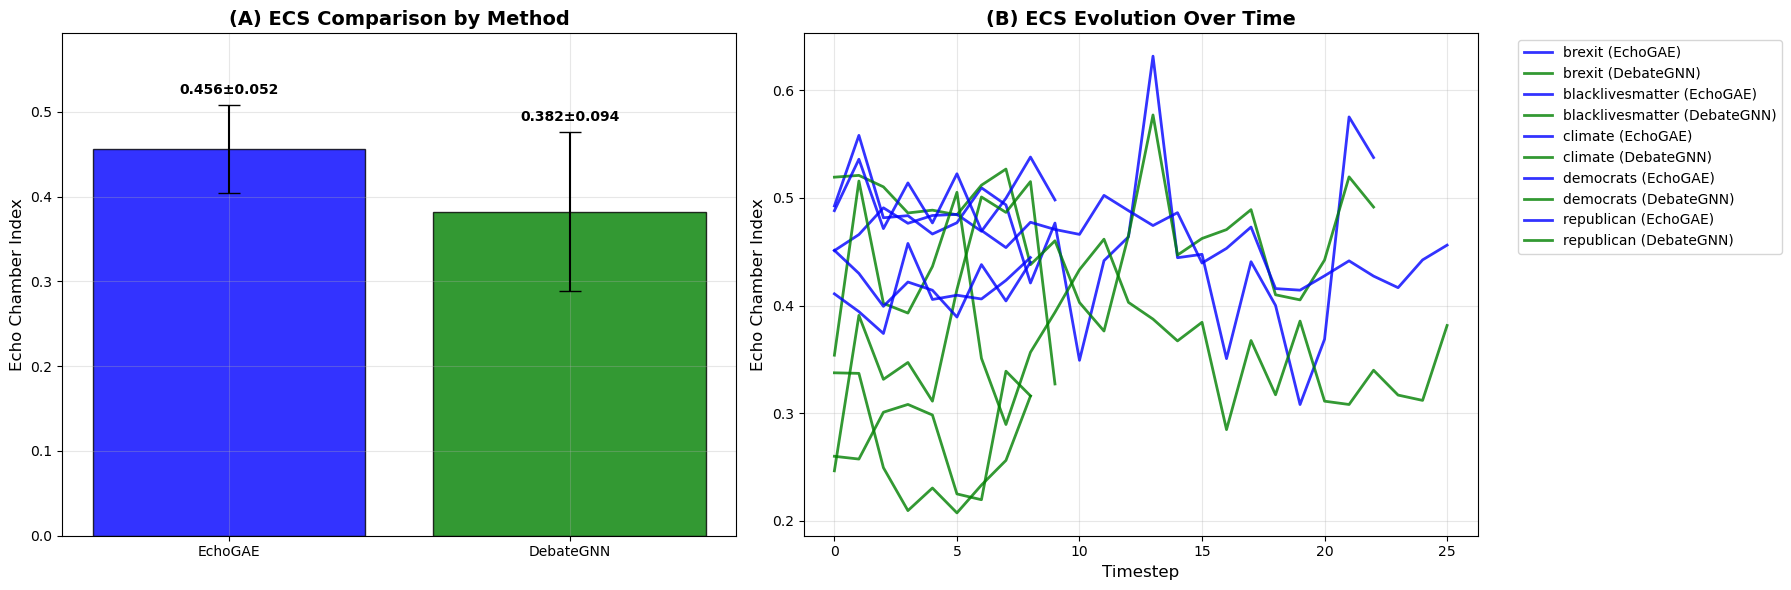

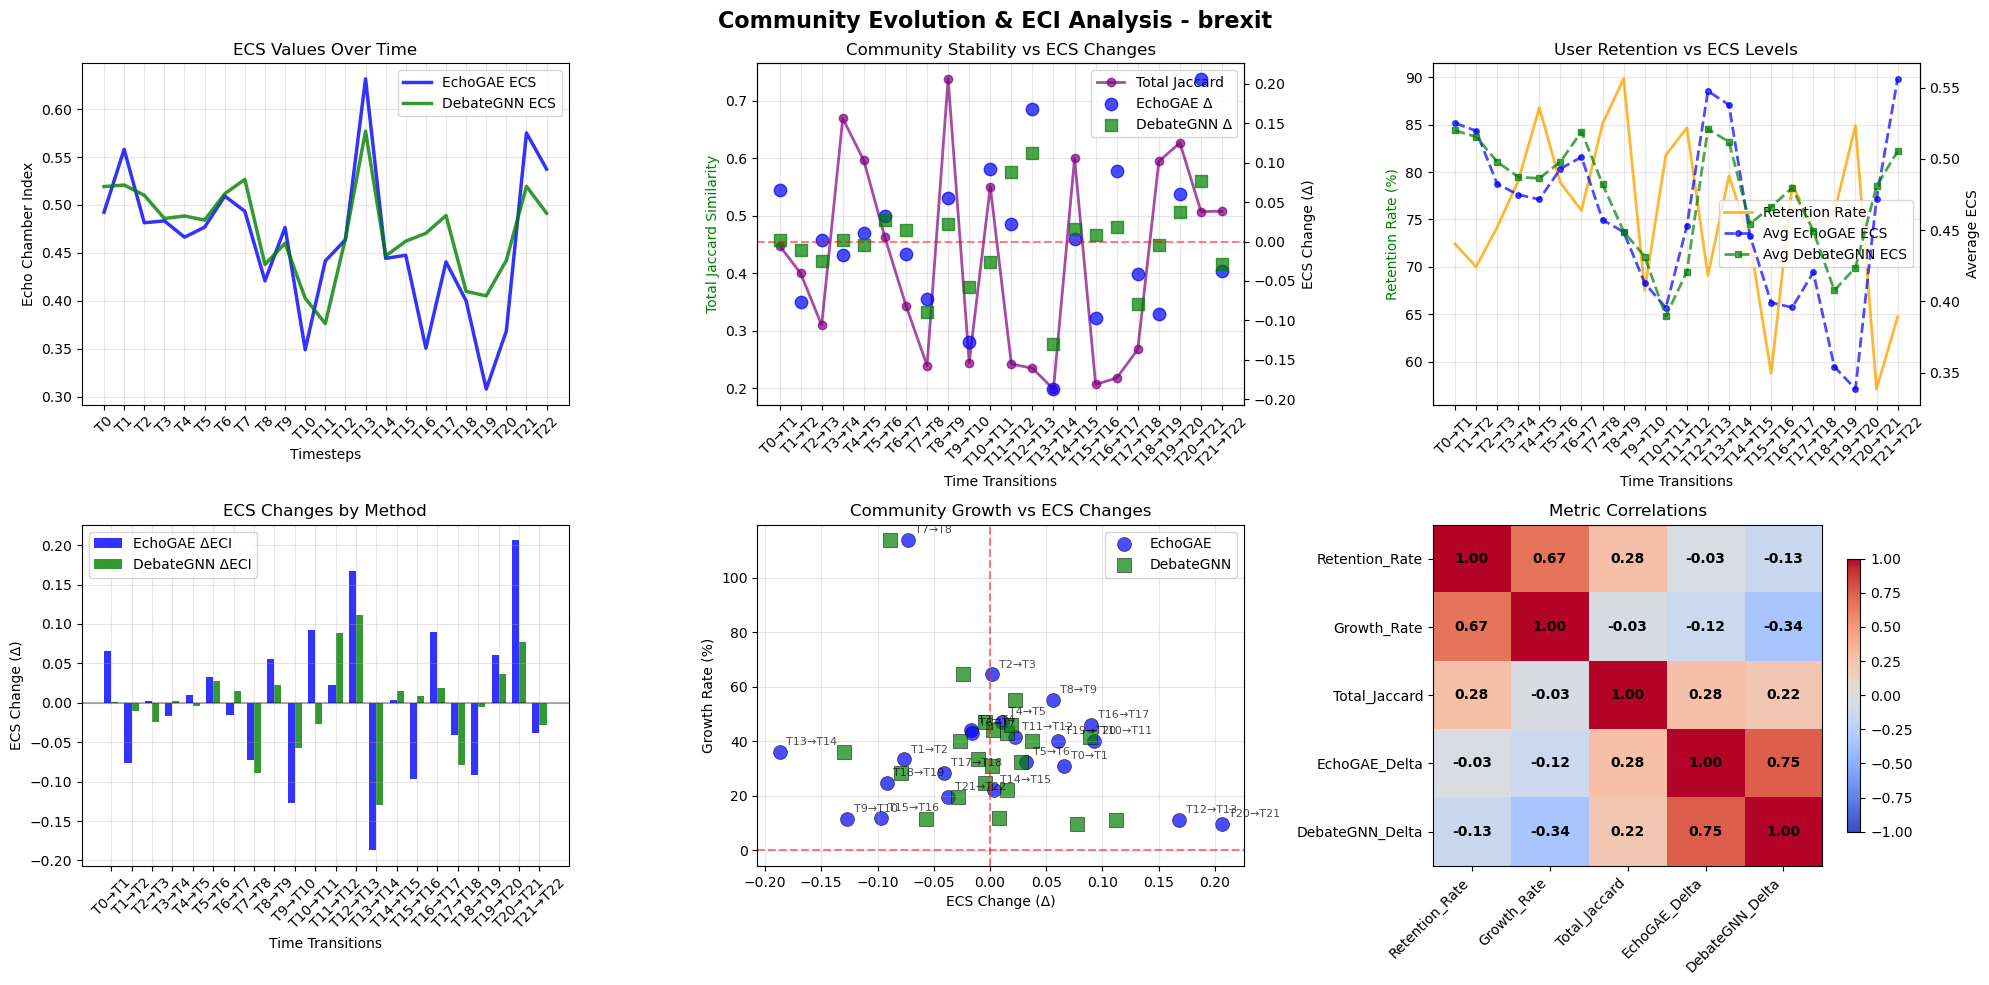


COMPREHENSIVE ANALYSIS SUMMARY - brexit

ECS EVOLUTION:
  + T0: EchoGAE=0.4924, DebateGNN=0.5192
  + T1: EchoGAE=0.5580, DebateGNN=0.5208
  + T2: EchoGAE=0.4815, DebateGNN=0.5102
  + T3: EchoGAE=0.4834, DebateGNN=0.4860
  + T4: EchoGAE=0.4664, DebateGNN=0.4885
  + T5: EchoGAE=0.4769, DebateGNN=0.4842
  + T6: EchoGAE=0.5093, DebateGNN=0.5117
  + T7: EchoGAE=0.4934, DebateGNN=0.5267
  + T8: EchoGAE=0.4209, DebateGNN=0.4379
  + T9: EchoGAE=0.4766, DebateGNN=0.4601
  + T10: EchoGAE=0.3491, DebateGNN=0.4028
  + T11: EchoGAE=0.4417, DebateGNN=0.3763
  + T12: EchoGAE=0.4638, DebateGNN=0.4651
  + T13: EchoGAE=0.6315, DebateGNN=0.5769
  + T14: EchoGAE=0.4444, DebateGNN=0.4469
  + T15: EchoGAE=0.4476, DebateGNN=0.4623
  + T16: EchoGAE=0.3507, DebateGNN=0.4705
  + T17: EchoGAE=0.4407, DebateGNN=0.4890
  + T18: EchoGAE=0.4001, DebateGNN=0.4100
  + T19: EchoGAE=0.3081, DebateGNN=0.4053
  + T20: EchoGAE=0.3687, DebateGNN=0.4423
  + T21: EchoGAE=0.5751, DebateGNN=0.5195
  + T22: EchoGAE=0.5374, Deba

c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  NetworkX coloring: 261 nodes with colors, 0 nodes without colors
  Community layout: 3 communities for positioning


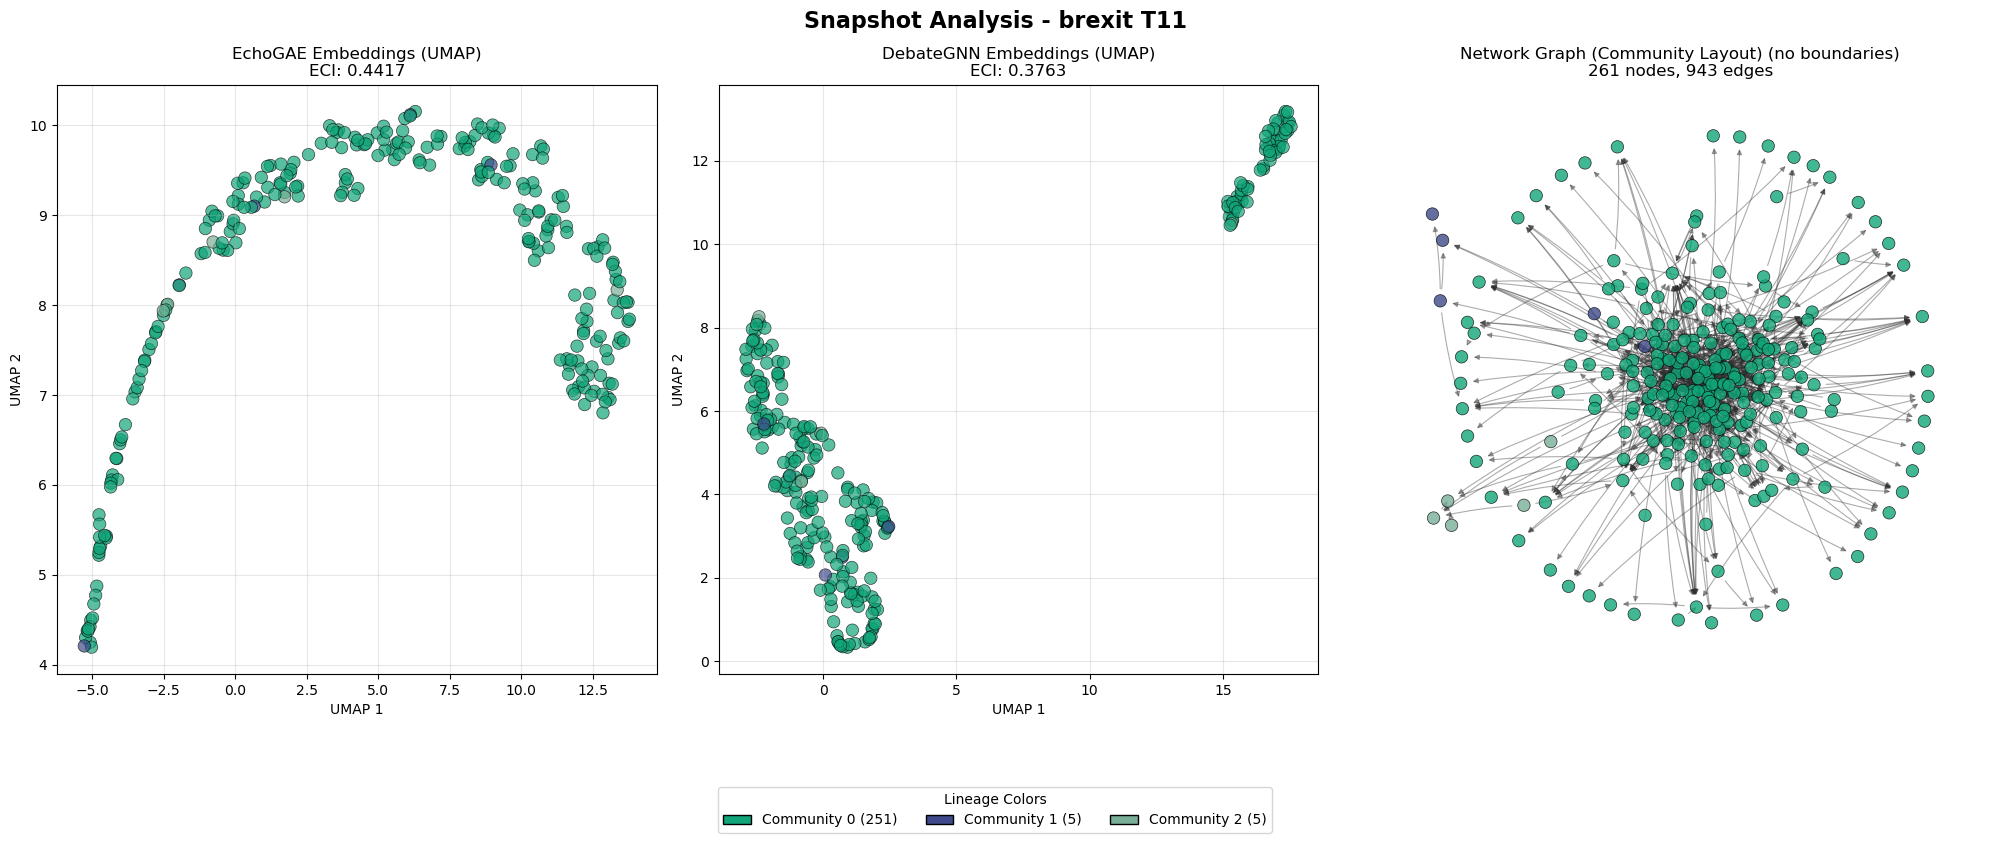


SNAPSHOT SUMMARY - brexit T11
Communities: 3
Nodes: 261
Edges: 943
Modularity: 0.017
EchoGAE ECI: 0.4417
DebateGNN ECI: 0.3763
Color scheme: Lineage Colors
Boundaries drawn: False
  Community 0: 251 nodes, EchoGAE ECI: 0.4377, DebateGNN ECI: 0.3688
  Community 1: 5 nodes, EchoGAE ECI: 0.4501, DebateGNN ECI: 0.7219
  Community 2: 5 nodes, EchoGAE ECI: 0.6296, DebateGNN ECI: 0.4101
Analyzing ALL user flows with thresholds:
  + Minimum flow: 3 users
  + Minimum Jaccard similarity: 0.050

Transition T0 → T1:
  Found 2 significant flows (filtered out 4):
    C1→C0: 8 users (J=0.348, Medium)
    C0→C0: 7 users (J=0.259, Low)

Transition T1 → T2:
  Found 2 significant flows (filtered out 2):
    C0→C0: 14 users (J=0.400, Medium)
    C1→C0: 6 users (J=0.194, Low)

Transition T2 → T3:
  Found 3 significant flows (filtered out 5):
    C0→C0: 6 users (J=0.167, Low)
    C0→C1: 6 users (J=0.171, Low)
    C0→C2: 6 users (J=0.176, Low)

Transition T3 → T4:
  Found 7 significant flows (filtered out 9


ALL FLOWS SANKEY SUMMARY - r/brexit - Community Flow Analysis
FILTERING RESULTS:
  + Total possible flows: 271
  + Flows after filtering: 119
  + Filtered out: 152 (56.1%)
  + Filter efficiency: 43.9% flows retained

FLOW STATISTICS:
  + Total nodes (communities): 80
  + Total links (significant flows): 119
  + Total users in flows: 2,802
  + Average flow size: 23.5 users
  + Average Jaccard similarity: 0.150

FLOW STRENGTH DISTRIBUTION:
  + Strong: 5 flows (4.2%)
  + Medium: 2 flows (1.7%)
  + Low: 65 flows (54.6%)
  + Very Low: 47 flows (39.5%)
  T0 → T1: 2 flows, 15 total users, avg Jaccard: 0.304
  T1 → T2: 2 flows, 20 total users, avg Jaccard: 0.297
  T2 → T3: 3 flows, 18 total users, avg Jaccard: 0.172
  T3 → T4: 7 flows, 26 total users, avg Jaccard: 0.165
  T4 → T5: 9 flows, 42 total users, avg Jaccard: 0.146
  T5 → T6: 6 flows, 56 total users, avg Jaccard: 0.176
  T6 → T7: 2 flows, 57 total users, avg Jaccard: 0.282
  T7 → T8: 6 flows, 76 total users, avg Jaccard: 0.115
  T8 →

TypeError: string indices must be integers, not 'str'

In [13]:
import importlib
import src.visualization.ecs_plots
import src.visualization.snapshot_plots
import src.visualization.community_migration_plots
import src.visualization.community_sankey_plots
importlib.reload(src.visualization.ecs_plots)
importlib.reload(src.visualization.snapshot_plots)
importlib.reload(src.visualization.community_migration_plots)
importlib.reload(src.visualization.community_sankey_plots)

# Then reload the ECS analyzer which uses it
import src.analysis.ecs_analyzer
importlib.reload(src.analysis.ecs_analyzer)

from src.analysis.ecs_analyzer import ECSAnalyzer

analyzer = ECSAnalyzer(output_dir='results')
results = analyzer.run_complete_analysis_with_figures(
    processed_dict=processed_dict,
    ecs_df=ecs_df,
    target_subreddit_id=0,
    save_figures=False
)

### **ECS Pipeline**

In [ ]:
# pyg_graphs = graph_data.pyg_graphs
# graph_dict = graph_data.graph_dict

# import numpy as np
# import networkx as nx
# from torch_geometric.utils import to_networkx

# from src.baselines.echogae import EchoChamberMeasure, EchoGAE_algorithm
# from src.modules.community_processor import LeidenCommunityProcessor

# import warnings
# warnings.filterwarnings("ignore", message="Converting a tensor with requires_grad=True to a scalar")
# warnings.filterwarnings("ignore", message="'train_test_split_edges' is deprecated")

# # Initialize community processor
# processed_path = base_configs.get('processed_path', 'data/processed')
# leiden_processor = LeidenCommunityProcessor(community_configs=community_cfg, output_dir=processed_path)

# processed_dict = {}

# pyg_graphs = graph_data.pyg_graphs

# import numpy as np
# import networkx as nx
# from torch_geometric.utils import to_networkx

# from src.baselines.echogae import EchoChamberMeasure, EchoGAE_algorithm
# from src.modules.community_processor import LeidenCommunityProcessor

# import warnings
# warnings.filterwarnings("ignore", message="Converting a tensor with requires_grad=True to a scalar")
# warnings.filterwarnings("ignore", message="'train_test_split_edges' is deprecated")

# # Initialize community processor
# processed_path = base_configs.get('processed_path', 'data/processed')
# leiden_processor = LeidenCommunityProcessor(community_configs=community_cfg, output_dir=processed_path)

# processed_dict = {}

# # Add this after your ECI calculations in the ECS Pipeline
# def analyze_embedding_community_alignment(embeddings, comm_labels, comm_nodes, method_name):
#     """Check how well embeddings align with community structure"""
#     from sklearn.metrics import silhouette_score
#     from scipy.spatial.distance import pdist, squareform
    
#     # Calculate silhouette score (higher = better cluster separation)
#     sil_score = silhouette_score(embeddings, comm_labels)
    
#     # Calculate average intra/inter community distances
#     dist_matrix = squareform(pdist(embeddings, metric='cosine'))
    
#     intra_distances = []
#     inter_distances = []
    
#     for i in range(len(comm_labels)):
#         for j in range(i+1, len(comm_labels)):
#             if comm_labels[i] == comm_labels[j]:
#                 intra_distances.append(dist_matrix[i, j])
#             else:
#                 inter_distances.append(dist_matrix[i, j])
    
#     avg_intra = np.mean(intra_distances) if intra_distances else 0
#     avg_inter = np.mean(inter_distances) if inter_distances else 0
    
#     print(f"{method_name} Embedding-Community Alignment:")
#     print(f"  Silhouette Score: {sil_score:.4f} (higher = better separation)")
#     print(f"  Avg Intra-Community Distance: {avg_intra:.4f}")
#     print(f"  Avg Inter-Community Distance: {avg_inter:.4f}")
#     print(f"  Distance Ratio (Inter/Intra): {avg_inter/avg_intra:.4f}" if avg_intra > 0 else "  Distance Ratio: inf")
    
#     return {
#         'silhouette': sil_score,
#         'avg_intra_dist': avg_intra,
#         'avg_inter_dist': avg_inter,
#         'distance_ratio': avg_inter/avg_intra if avg_intra > 0 else float('inf')
#     }


# for i in pyg_graphs:
#     sub = i.subreddit_id if hasattr(i, 'subreddit_id') else None
#     ts = i.local_timestep if hasattr(i, 'local_timestep') else None
#     print(f"Processing graph for subreddit: {sub}, timestep: {ts}")
    
#     if sub is None or ts is None:
#         print("Skipping - missing subreddit_id or timestep")
#         continue

#     # EXTRACT NODE MAPPING from PyG graph
#     index_to_user_mapping = None
#     if hasattr(i, 'node_map') and i.node_map is not None:
#         # node_map is {user_id: index}, we need {index: user_id}
#         user_to_index = i.node_map
#         index_to_user_mapping = {idx: user_id for user_id, idx in user_to_index.items()}
#         # Convert to list ordered by index
#         max_idx = max(index_to_user_mapping.keys()) if index_to_user_mapping else -1
#         index_to_user_list = [None] * (max_idx + 1)
#         for idx, user_id in index_to_user_mapping.items():
#             index_to_user_list[idx] = user_id
#         index_to_user_mapping = index_to_user_list
#         print(f"  Extracted node mapping: {len(index_to_user_mapping)} nodes, sample: {index_to_user_mapping[:5]}")
#     else:
#         print("  No node_map found in PyG graph")

#     # Extract node features
#     node_features = i.x.cpu().numpy() if hasattr(i, 'x') and i.x is not None else None
    
#     # USE ORIGINAL GRAPH WITH NODE NAMES from graph_dict instead of PyG conversion
#     nx_graph = graph_dict[sub][ts]
    
#     # Convert PyG to nx only for EchoGAE
#     pyg_nx_graph = to_networkx(i, to_undirected=False)
    
#     # Check connectivity
#     if nx_graph.number_of_nodes() > 0:
#         wcc = list(nx.weakly_connected_components(nx_graph))
#         largest_wcc = max(wcc, key=len) if wcc else set()

#     # Get EchoGAE node embeddings (use PyG converted graph for structure)
#     echogae_embeddings, _, _, _, _ = EchoGAE_algorithm(
#         G=pyg_nx_graph.to_undirected(),
#         user_embeddings=node_features,
#         show_progress=False,
#         epochs=50,
#         hidden_channels=100,
#         out_channels=50,
#         seed=42
#     )
    
#     # Get GNN node embeddings
#     gnn_embeddings = gnn_model.embed(i, device=device, eval_mode=True) if gnn_model else None

#     # Run optimization for this single graph
#     single_graph_dict = {sub: {ts: graph_dict[sub][ts]}}
    
#     opt_meta, scans_df, best_df, summary_df = leiden_processor.analyze_optimal_community_parameters(single_graph_dict)
    
#     # Run community detection with optimization results
#     community_result = leiden_processor.run_community_detection(
#         graph_dict=single_graph_dict,
#         use_optimization=True,
#         save=False
#     )
    
#     # Get community labels and partition
#     comm_labels = community_result.labels_array[sub][ts]
#     partition_nx = community_result.labels_name_dict[sub][ts]  # node_id -> community_id
    
#     # Debug: Check actual constraints vs requirements
#     unique_communities = np.unique(comm_labels)
#     comm_sizes = [np.sum(comm_labels == comm_id) for comm_id in unique_communities]
#     num_communities = len(unique_communities)
#     min_comm_size_actual = min(comm_sizes) if comm_sizes else 0
    
#     # Get constraints from config
#     min_communities_required = community_cfg.get('optimization', {}).get('min_communities', 2)
#     min_size_required = community_cfg.get('optimization', {}).get('min_community_size', 10)
    
#     print(f"  Graph stats: {nx_graph.number_of_nodes()} nodes, {nx_graph.number_of_edges()} edges")
#     print(f"  Communities found: {num_communities} (min required: {min_communities_required})")
#     print(f"  Community sizes (min={min_comm_size_actual}): {comm_sizes} (min size required: {min_size_required})")
    
#     # Check if constraints can theoretically be satisfied
#     theoretical_min_nodes = min_communities_required * min_size_required
#     if nx_graph.number_of_nodes() < theoretical_min_nodes:
#         print(f"  WARNING: Graph has {nx_graph.number_of_nodes()} nodes but needs at least {theoretical_min_nodes} to satisfy constraints!")
    
#     # Calculate modularity (if available in community_result)
#     nx_modularity = None
#     if hasattr(community_result, 'partitions') and not community_result.partitions.empty:
#         # Find the row for current subreddit and timestep
#         partition_row = community_result.partitions[
#             (community_result.partitions['subreddit_id'] == sub) & 
#             (community_result.partitions['timestep'] == ts)
#         ]
#         if not partition_row.empty:
#             nx_modularity = partition_row['modularity'].iloc[0]
    
#     print(f"  Modularity: {nx_modularity:.3f}")

#     # Community sizes
#     nx_comm_sizes = [np.sum(comm_labels == comm_id) for comm_id in unique_communities]
#     nx_min_comm_size = min(nx_comm_sizes)
#     nx_max_comm_size = max(nx_comm_sizes)
#     nx_mean_comm_size = np.mean(nx_comm_sizes)
    
#     # Build comm_nodes directly from partition (user_id -> community_id)
#     nx_comm_nodes = {}
#     for comm_id in unique_communities:
#         nx_comm_nodes[comm_id] = []
    
#     # Populate comm_nodes from partition
#     for user_id, comm_id in partition_nx.items():
#         if comm_id in nx_comm_nodes:
#             nx_comm_nodes[comm_id].append(user_id)
    
#     # Debug: Print comm_nodes sizes to verify they're populated correctly
#     comm_nodes_sizes = {comm_id: len(users) for comm_id, users in nx_comm_nodes.items()}
#     print(f"  Community node counts: {comm_nodes_sizes}")
    
#     # Detailed community information
#     subreddit_map = {v: k for k, v in base_configs['subreddits'].items()}
#     community_info = {
#         'subreddit_id': sub,
#         'subreddit': subreddit_map.get(sub, f'Unknown_{sub}'),
#         'timestep': ts,
#         'num_nodes': nx_graph.number_of_nodes(),
#         'num_edges': nx_graph.number_of_edges(),
#         'num_communities': num_communities,
#         'modularity': nx_modularity,
#         'min_comm_size': nx_min_comm_size,
#         'max_comm_size': nx_max_comm_size,
#         'mean_comm_size': nx_mean_comm_size,
#         'partition': partition_nx,
#         'comm_labels': comm_labels,
#         'comm_sizes': nx_comm_sizes,
#         'comm_nodes': nx_comm_nodes,
#     }
    
#     # Calculate community and overall ECS for EchoGAE
#     echogae_ecm = EchoChamberMeasure(
#         users_representations=echogae_embeddings,
#         labels=comm_labels,
#     )
#     echogae_eci = echogae_ecm.echo_chamber_index()
#     echogae_comm_eci = [echogae_ecm.community_echo_chamber_index(i) for i in np.unique(comm_labels)]
#     print(f"  EchoGAE ECI: {echogae_eci:.4f} | Community ECIs: {[f'{eci:.4f}' for eci in echogae_comm_eci]}")

#     # Calculate community and overall ECS for DebateGNN
#     debgnn_ecm = EchoChamberMeasure(
#         users_representations=gnn_embeddings,
#         labels=comm_labels,
#     )
#     debgnn_eci = debgnn_ecm.echo_chamber_index()
#     debgnn_comm_eci = [debgnn_ecm.community_echo_chamber_index(i) for i in np.unique(comm_labels)]
#     print(f"  DebateGNN ECI: {debgnn_eci:.4f} | Community ECIs: {[f'{eci:.4f}' for eci in debgnn_comm_eci]}")
    
#     # ADD THE DIAGNOSTIC ANALYSIS HERE
#     print(f"\n  --- Embedding-Community Alignment Analysis ---")
#     echo_alignment = analyze_embedding_community_alignment(
#         echogae_embeddings, comm_labels, nx_comm_nodes, "EchoGAE")
#     debgnn_alignment = analyze_embedding_community_alignment(
#         gnn_embeddings, comm_labels, nx_comm_nodes, "DebateGNN")
#     print(f"  --- End Alignment Analysis ---\n")
    
#     # Store all data for this graph
#     if sub not in processed_dict:
#         processed_dict[sub] = {}
    
#     processed_dict[sub][ts] = {
#         'echogae_embeddings': echogae_embeddings,
#         'gnn_embeddings': gnn_embeddings.cpu().numpy() if gnn_embeddings is not None else None,
#         'node_features': node_features,
#         'community_info': community_info,
#         'echogae_eci': echogae_eci,
#         'echogae_comm_eci': echogae_comm_eci,
#         'debgnn_eci': debgnn_eci,
#         'debgnn_comm_eci': debgnn_comm_eci,
#         'nx_graph': nx_graph,
#         'echogae_alignment': echo_alignment,
#         'debgnn_alignment': debgnn_alignment,
#         'index_to_user': index_to_user_mapping, 
#     }

# print(f"\nProcessed {len(processed_dict)} subreddits")

Processing graph for subreddit: 0, timestep: 0
  Extracted node mapping: 29 nodes, sample: ['APB2710', 'AnomalyNexus', 'ArchbishopMegatronQC', 'Bozata1', 'EthiczGradient']
Using device: cuda
  Graph stats: 29 nodes, 84 edges
  Communities found: 3 (min required: 2)
  Community sizes (min=6): [np.int64(13), np.int64(10), np.int64(6)] (min size required: 3)
  Modularity: 0.238
  Community node counts: {np.int64(0): 13, np.int64(1): 10, np.int64(2): 6}
  EchoGAE ECI: 0.4952 | Community ECIs: ['0.4173', '0.6083', '0.4756']
  DebateGNN ECI: 0.5192 | Community ECIs: ['0.5976', '0.4440', '0.4745']

  --- Embedding-Community Alignment Analysis ---
EchoGAE Embedding-Community Alignment:
  Silhouette Score: -0.1002 (higher = better separation)
  Avg Intra-Community Distance: 0.7297
  Avg Inter-Community Distance: 0.7852
  Distance Ratio (Inter/Intra): 1.0760
DebateGNN Embedding-Community Alignment:
  Silhouette Score: -0.0516 (higher = better separation)
  Avg Intra-Community Distance: 0.4414
  

In [22]:
import pandas as pd

# Create a combined DataFrame from community info
combined_data = []

for subreddit_id, timesteps in processed_dict.items():
    for timestep, data in timesteps.items():
        community_info = data['community_info']
        
        # Create a row with all the community information
        row = {
            'subreddit_id': subreddit_id,
            'subreddit': community_info['subreddit'],
            'timestep': timestep,
            'num_nodes': community_info['num_nodes'],
            'num_edges': community_info['num_edges'],
            'num_communities': community_info['num_communities'],
            'modularity': round(community_info['modularity'], 3) if community_info['modularity'] is not None else None,
            'min_comm_size': community_info['min_comm_size'],
            'max_comm_size': community_info['max_comm_size'],
            'mean_comm_size': round(community_info['mean_comm_size'], 1),
            'echogae_eci': round(data['echogae_eci'], 3),
            'debgnn_eci': round(data['debgnn_eci'], 3),
            # Convert numpy arrays to Python lists with native types
            'comm_sizes': [int(size) for size in community_info['comm_sizes']],
            'echogae_comm_eci': [round(float(eci), 3) for eci in data['echogae_comm_eci']],
            'debgnn_comm_eci': [round(float(eci), 3) for eci in data['debgnn_comm_eci']],
            'echogae_silhouette': round(data['echogae_alignment']['silhouette'], 4),
            'debgnn_silhouette': round(data['debgnn_alignment']['silhouette'], 4),
        }
        
        combined_data.append(row)

# Create DataFrame
eci_df = pd.DataFrame(combined_data)

# Add delta columns for ECI changes between timesteps
eci_df = eci_df.sort_values(['subreddit_id', 'timestep']).reset_index(drop=True)

# Calculate deltas within each subreddit group
eci_df['delta_echogae_eci'] = eci_df.groupby('subreddit_id')['echogae_eci'].diff()
eci_df['delta_debgnn_eci'] = eci_df.groupby('subreddit_id')['debgnn_eci'].diff()

# Round the delta values to 3 decimal places
eci_df['delta_echogae_eci'] = eci_df['delta_echogae_eci'].round(4)
eci_df['delta_debgnn_eci'] = eci_df['delta_debgnn_eci'].round(4)

# Sort by subreddit and timestep
eci_df = eci_df.sort_values(['subreddit_id', 'timestep']).reset_index(drop=True)

print(f"Created combined DataFrame with {len(eci_df)} rows")
print("\nDataFrame columns:", list(eci_df.columns))
print("\nFirst few rows:")
display(eci_df.head(11))

# # Save results to csv
# eci_df.to_csv('results/eci_results.csv', index=False)
# print("Saved results to results/eci_results.csv")

Created combined DataFrame with 77 rows

DataFrame columns: ['subreddit_id', 'subreddit', 'timestep', 'num_nodes', 'num_edges', 'num_communities', 'modularity', 'min_comm_size', 'max_comm_size', 'mean_comm_size', 'echogae_eci', 'debgnn_eci', 'comm_sizes', 'echogae_comm_eci', 'debgnn_comm_eci', 'echogae_silhouette', 'debgnn_silhouette', 'delta_echogae_eci', 'delta_debgnn_eci']

First few rows:


subreddit_id subreddit  timestep  num_nodes  num_edges  num_communities  \
0              0    brexit         0         29         84                3   
1              0    brexit         1         30         79                2   
2              0    brexit         2         31         59                2   
3              0    brexit         3         43        107                4   
4              0    brexit         4         53        134                4   
5              0    brexit         5         71        266                3   
6              0    brexit         6         79        187                2   
7              0    brexit         7         94        176                2   
8              0    brexit         8        187        611                6   
9              0    brexit         9        271       1090                6   
10             0    brexit        10        214        555                3   

    modularity  min_comm_size  max_comm_size  mean_comm_size  echogae_eci  \
0        0.238              6             13             9.7        0.512   
1        0.213              9             21            15.0        0.554   
2        0.064              3             28            15.5        0.438   
3        0.305              4             14            10.8        0.494   
4        0.328             11             14            13.2        0.471   
5        0.279             22             26            23.7        0.490   
6        0.296             36             43            39.5        0.508   
7        0.033              4             90            47.0        0.492   
8        0.339             12             48            31.2        0.418   
9        0.303             11             70            45.2        0.456   
10       0.014              3            208            71.3        0.349   

    debgnn_eci                comm_sizes  \
0        0.519               [13, 10, 6]   
1        0.521                   [21, 9]   
2        0.510                   [28, 3]   
3        0.486           [14, 13, 12, 4]   
4        0.489          [14, 14, 14, 11]   
5        0.484              [26, 23, 22]   
6        0.512                  [43, 36]   
7        0.527                   [90, 4]   
8        0.438  [48, 38, 34, 32, 23, 12]   
9        0.460  [70, 68, 65, 36, 21, 11]   
10       0.403               [208, 3, 3]   

                              echogae_comm_eci  \
0                        [0.503, 0.539, 0.486]   
1                               [0.557, 0.545]   
2                               [0.408, 0.723]   
3                  [0.49, 0.518, 0.459, 0.538]   
4                 [0.438, 0.546, 0.421, 0.483]   
5                          [0.513, 0.54, 0.41]   
6                               [0.488, 0.533]   
7                               [0.483, 0.692]   
8    [0.376, 0.387, 0.376, 0.433, 0.582, 0.45]   
9   [0.445, 0.436, 0.431, 0.529, 0.502, 0.464]   
10                        [0.34, 0.541, 0.785]   

                               debgnn_comm_eci  echogae_silhouette  \
0                        [0.598, 0.444, 0.474]             -0.0731   
1                               [0.506, 0.555]              0.0520   
2                               [0.502, 0.582]             -0.1763   
3                 [0.509, 0.435, 0.495, 0.544]             -0.1025   
4                 [0.452, 0.538, 0.465, 0.502]             -0.1264   
5                        [0.527, 0.446, 0.474]             -0.0571   
6                                 [0.53, 0.49]             -0.0070   
7                                [0.527, 0.53]             -0.0334   
8   [0.407, 0.474, 0.412, 0.408, 0.464, 0.551]             -0.1901   
9    [0.454, 0.424, 0.48, 0.517, 0.442, 0.453]             -0.1081   
10                         [0.397, 0.56, 0.65]             -0.3130   

    debgnn_silhouette  delta_echogae_eci  delta_debgnn_eci  
0             -0.0516                NaN               NaN  
1             -0.0218              0.

In [23]:
delta_eci_summary = eci_df.groupby('subreddit').agg({
    'timestep': 'count',
    'echogae_eci': ['mean', 'min', 'max'],
    'delta_echogae_eci': ['mean', 'min', 'max'],
    'debgnn_eci': ['mean', 'min', 'max'],
    'delta_debgnn_eci': ['mean', 'min', 'max'],
    'echogae_silhouette': ['mean', 'min', 'max'],
    'debgnn_silhouette': ['mean', 'min', 'max'],
})
display(delta_eci_summary)

# # Save results to csv
# delta_eci_summary.to_csv('results/delta_eci_summary.csv')
# print("Saved summary to results/delta_eci_summary.csv")

timestep echogae_eci               delta_echogae_eci         \
                    count        mean    min    max              mean    min   
subreddit                                                                      
blacklivesmatter       10    0.484100  0.441  0.548          0.005778 -0.055   
brexit                 23    0.459087  0.297  0.669          0.001364 -0.222   
climate                26    0.467885  0.412  0.529         -0.001240 -0.053   
democrats               9    0.406667  0.361  0.456          0.005000 -0.055   
republican              9    0.420000  0.385  0.451         -0.001375 -0.029   

                        debgnn_eci               delta_debgnn_eci         \
                    max       mean    min    max             mean    min   
subreddit                                                                  
blacklivesmatter  0.050   0.381800  0.288  0.475         0.004444 -0.074   
brexit            0.205   0.474000  0.376  0.577        -0.001273 -0.130   
climate           0.037   0.375346  0.285  0.516         0.001080 -0.154   
democrats         0.095   0.280444  0.220  0.339         0.007000 -0.073   
republican        0.047   0.264222  0.208  0.338        -0.002750 -0.088   

                        echogae_silhouette                 debgnn_silhouette  \
                    max               mean     min     max              mean   
subreddit                                                                      
blacklivesmatter  0.079          -0.182710 -0.2201 -0.0898         -0.356340   
brexit            0.112          -0.109126 -0.4108  0.3339         -0.079896   
climate           0.162          -0.124508 -0.2079  0.0315         -0.298427   
democrats         0.119          -0.211133 -0.2878 -0.0981         -0.455667   
republican        0.060          -0.199744 -0.2615 -0.1494         -0.497333   

                                  
                     min     max  
subreddit                         
blacklivesmatter -0.5028 -0.2169  
brexit           -0.2559  0.1493  
climate          -0.4551  0.0074  
democrats        -0.5793 -0.3476  
republican       -0.6032 -0.3589

### **Community Evolution**
By Subreddit

In [14]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from typing import Dict, List, Tuple, Optional, Any

class CommunityEvolutionAnalyzer:
    """
    A class for analyzing community evolution using Jaccard similarity and Hungarian algorithm matching.
    """
    
    def __init__(self, verbose: bool = True, matrix_display_limit: Optional[int] = None):
        """
        Initialize the Community Evolution Analyzer.
        
        Args:
            verbose: Whether to print detailed output during analysis
            matrix_display_limit: Maximum number of rows/columns to display in matrix 
                                 (None = show all, int = limit)
        """
        self.verbose = verbose
        self.matrix_display_limit = matrix_display_limit
    
    @staticmethod
    def compute_jaccard_similarity(c1: List, c2: List) -> float:
        """Compute Jaccard similarity between two communities (sets of users)."""
        set1, set2 = set(c1), set(c2)
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0
    
    def compute_community_jaccard_matrix(self, comms_t1: Dict, comms_t2: Dict) -> Tuple[np.ndarray, List, List]:
        """
        Compute Jaccard similarity matrix between communities at two timesteps.
        
        Args:
            comms_t1: dict {community_id: list_of_users} for timestep t1
            comms_t2: dict {community_id: list_of_users} for timestep t2
        
        Returns:
            jaccard_matrix: 2D numpy array where [i,j] = Jaccard(comm_i_t1, comm_j_t2)
            comm_ids_t1: list of community IDs for t1 (rows)
            comm_ids_t2: list of community IDs for t2 (columns)
        """
        comm_ids_t1 = sorted(comms_t1.keys())
        comm_ids_t2 = sorted(comms_t2.keys())
        
        n_t1, n_t2 = len(comm_ids_t1), len(comm_ids_t2)
        jaccard_matrix = np.zeros((n_t1, n_t2))
        
        for i, comm_id_t1 in enumerate(comm_ids_t1):
            for j, comm_id_t2 in enumerate(comm_ids_t2):
                jaccard_matrix[i, j] = self.compute_jaccard_similarity(
                    comms_t1[comm_id_t1], 
                    comms_t2[comm_id_t2]
                )
        
        return jaccard_matrix, comm_ids_t1, comm_ids_t2
    
    def find_best_matches_hungarian(self, jaccard_matrix: np.ndarray, comm_ids_t1: List, 
                                   comm_ids_t2: List, comms_t1: Dict, comms_t2: Dict) -> Tuple[List, float]:
        """
        Find optimal community matches using Hungarian algorithm.
        
        Args:
            jaccard_matrix: Jaccard similarity matrix
            comm_ids_t1, comm_ids_t2: Community IDs for each timestep
            comms_t1, comms_t2: Community user dictionaries
        
        Returns:
            matches: List of match dictionaries with optimal assignments
            total_jaccard: Sum of Jaccard similarities for optimal matching
        """
        # Hungarian algorithm minimizes cost, but we want to maximize Jaccard
        cost_matrix = 1 - jaccard_matrix
        
        # Handle case where dimensions don't match by padding with high cost
        n_t1, n_t2 = jaccard_matrix.shape
        if n_t1 != n_t2:
            max_dim = max(n_t1, n_t2)
            padded_cost_matrix = np.ones((max_dim, max_dim))
            padded_cost_matrix[:n_t1, :n_t2] = cost_matrix
            cost_matrix = padded_cost_matrix
        
        # Run Hungarian algorithm
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        # Extract valid matches (not dummy assignments)
        matches = []
        total_jaccard = 0.0
        
        for i, j in zip(row_indices, col_indices):
            if i < n_t1 and j < n_t2:  # Valid assignment (not dummy)
                comm_t1 = comm_ids_t1[i]
                comm_t2 = comm_ids_t2[j]
                jaccard_score = jaccard_matrix[i, j]
                
                matches.append({
                    't1_comm': comm_t1,
                    't2_comm': comm_t2,
                    'jaccard': jaccard_score,
                    't1_size': len(comms_t1[comm_t1]),
                    't2_size': len(comms_t2[comm_t2]),
                    'assignment_type': 'matched'
                })
                total_jaccard += jaccard_score
        
        # Handle unmatched communities
        matched_t1 = {match['t1_comm'] for match in matches}
        matched_t2 = {match['t2_comm'] for match in matches}
        
        # Unmatched t1 communities (disappeared)
        for comm_t1 in comm_ids_t1:
            if comm_t1 not in matched_t1:
                matches.append({
                    't1_comm': comm_t1,
                    't2_comm': None,
                    'jaccard': 0.0,
                    't1_size': len(comms_t1[comm_t1]),
                    't2_size': 0,
                    'assignment_type': 'disappeared'
                })
        
        # Unmatched t2 communities (emerged)
        for comm_t2 in comm_ids_t2:
            if comm_t2 not in matched_t2:
                matches.append({
                    't1_comm': None,
                    't2_comm': comm_t2,
                    'jaccard': 0.0,
                    't1_size': 0,
                    't2_size': len(comms_t2[comm_t2]),
                    'assignment_type': 'emerged'
                })
        
        return matches, total_jaccard
    
    @staticmethod
    def analyze_user_migration_statistics(comms_t1: Dict, comms_t2: Dict) -> Dict:
        """Analyze user migration patterns between timesteps."""
        users_t1 = set().union(*comms_t1.values()) if comms_t1 else set()
        users_t2 = set().union(*comms_t2.values()) if comms_t2 else set()
        
        retained_users = users_t1.intersection(users_t2)
        new_users = users_t2 - users_t1
        lost_users = users_t1 - users_t2
        
        return {
            'total_t1': len(users_t1),
            'total_t2': len(users_t2),
            'retained': len(retained_users),
            'new': len(new_users),
            'lost': len(lost_users),
            'retention_rate': len(retained_users) / len(users_t1) if users_t1 else 0,
            'growth_rate': len(new_users) / len(users_t1) if users_t1 else 0
        }
    
    def print_jaccard_matrix(self, jaccard_matrix: np.ndarray, t1: int, t2: int, 
                           comm_ids_t1: List, comm_ids_t2: List) -> None:
        """Print formatted Jaccard matrix with proper alignment."""
        print(f"\nJaccard Similarity Matrix (T{t1} -> T{t2}):")
        print(f"Rows: T{t1} communities, Columns: T{t2} communities")
        print(f"Shape: {jaccard_matrix.shape}")
        
        # Determine how many rows/cols to display
        if self.matrix_display_limit is None:
            max_rows = len(comm_ids_t1)
            max_cols = len(comm_ids_t2)
            print("Full matrix:")
        else:
            max_rows = min(self.matrix_display_limit, len(comm_ids_t1))
            max_cols = min(self.matrix_display_limit, len(comm_ids_t2))
            print(f"Matrix (first {max_rows}x{max_cols}):")
        
        # Create column headers with actual timestep values
        col_headers = [f"T{t2}_C{comm_ids_t2[j]}" for j in range(max_cols)]
        header_str = "      " + " ".join([f"{header:>8}" for header in col_headers])
        print(header_str)
        
        # Print rows with actual timestep values
        display_matrix = jaccard_matrix[:max_rows, :max_cols]
        for i, row in enumerate(display_matrix):
            if i < len(comm_ids_t1):
                row_label = f"T{t1}_C{comm_ids_t1[i]}"
                row_str = " ".join([f"{val:>8.3f}" for val in row])
                print(f"{row_label:>5}: {row_str}")
    
    @staticmethod
    def print_migration_stats(migration_stats: Dict) -> None:
        """Print user migration statistics."""
        print(f"User Migration Statistics:")
        print(f"  Total users t1: {migration_stats['total_t1']}")
        print(f"  Total users t2: {migration_stats['total_t2']}")
        print(f"  Retained: {migration_stats['retained']} ({migration_stats['retention_rate']:.2%})")
        print(f"  New: {migration_stats['new']} ({migration_stats['growth_rate']:.2%})")
        print(f"  Lost: {migration_stats['lost']}")
    
    @staticmethod
    def print_hungarian_matches(matches: List, total_jaccard: float, t1: Optional[int] = None, 
                               t2: Optional[int] = None) -> None:
        """Print Hungarian algorithm matching results."""
        print(f"Hungarian Matching Results (Total Jaccard: {total_jaccard:.3f}):")
        
        # Use actual timestep values if provided
        t1_label = f"T{t1}" if t1 is not None else "T1"
        t2_label = f"T{t2}" if t2 is not None else "T2"
        
        # Group by assignment type
        matched = [m for m in matches if m['assignment_type'] == 'matched']
        disappeared = [m for m in matches if m['assignment_type'] == 'disappeared']
        emerged = [m for m in matches if m['assignment_type'] == 'emerged']
        
        print("  Matched communities:")
        for match in sorted(matched, key=lambda x: x['jaccard'], reverse=True):
            print(f"    {t1_label}_C{match['t1_comm']}({match['t1_size']}) -> "
                  f"{t2_label}_C{match['t2_comm']}({match['t2_size']}) | J={match['jaccard']:.3f}")
        
        if disappeared:
            print("  Disappeared communities:")
            for match in disappeared:
                print(f"    {t1_label}_C{match['t1_comm']}({match['t1_size']}) -> DISAPPEARED")
        
        if emerged:
            print("  Emerged communities:")
            for match in emerged:
                print(f"    EMERGED -> {t2_label}_C{match['t2_comm']}({match['t2_size']})")
    
    def analyze_evolution(self, subreddit_data: Dict) -> Optional[Dict]:
        """
        Compute Jaccard evolution for a single subreddit across timesteps using Hungarian algorithm.
        
        Args:
            subreddit_data: dict {timestep: {'community_info': {...}, ...}}
        
        Returns:
            evolution_data: dict containing evolution analysis results
        """
        ts = sorted(subreddit_data.keys())
        if len(ts) < 2:
            if self.verbose:
                print("Not enough timesteps to compute evolution.")
            return None
        
        evolution_data = {
            'timesteps': ts,
            'ts_pairs': [],
            'jaccard_matrices': [],
            'hungarian_matches': [],
            'total_jaccards': [],
            'migration_stats': [],
            'comm_ids_t1': [],
            'comm_ids_t2': []
        }
        
        if self.verbose:
            subreddit_name = subreddit_data[ts[0]]['community_info']['subreddit']
            print(f"Computing evolution for {subreddit_name} across {len(ts)} timesteps: {ts}")
        
        for i in range(len(ts) - 1):
            t1, t2 = ts[i], ts[i + 1]
            comm_data_t1 = subreddit_data[t1]['community_info']
            comm_data_t2 = subreddit_data[t2]['community_info']
            
            # Extract community nodes
            comms_t1 = comm_data_t1['comm_nodes']  # {comm_id: [users]}
            comms_t2 = comm_data_t2['comm_nodes']  # {comm_id: [users]}
            
            # Compute Jaccard matrix
            jaccard_matrix, comm_ids_t1, comm_ids_t2 = self.compute_community_jaccard_matrix(comms_t1, comms_t2)
            
            # Find optimal matches using Hungarian algorithm
            hungarian_matches, total_jaccard = self.find_best_matches_hungarian(
                jaccard_matrix, comm_ids_t1, comm_ids_t2, comms_t1, comms_t2
            )
            
            # Compute migration statistics
            migration_stats = self.analyze_user_migration_statistics(comms_t1, comms_t2)
            
            # Store results
            evolution_data['ts_pairs'].append((t1, t2))
            evolution_data['jaccard_matrices'].append(jaccard_matrix)
            evolution_data['hungarian_matches'].append(hungarian_matches)
            evolution_data['total_jaccards'].append(total_jaccard)
            evolution_data['migration_stats'].append(migration_stats)
            evolution_data['comm_ids_t1'].append(comm_ids_t1)
            evolution_data['comm_ids_t2'].append(comm_ids_t2)
            
            if self.verbose:
                print(f"\n--- Timestep {t1} -> {t2} ---")
                print(f"Communities: {len(comms_t1)} -> {len(comms_t2)}")
                self.print_jaccard_matrix(jaccard_matrix, t1, t2, comm_ids_t1, comm_ids_t2)
                self.print_hungarian_matches(hungarian_matches, total_jaccard, t1, t2)
                self.print_migration_stats(migration_stats)
        
        return evolution_data
    
    def analyze_multiple_subreddits(self, processed_dict: Dict) -> Dict:
        """
        Analyze evolution for multiple subreddits.
        
        Args:
            processed_dict: dict {subreddit_id: {timestep: data}}
        
        Returns:
            all_evolution_data: dict {subreddit_id: evolution_data}
        """
        all_evolution_data = {}
        
        for subreddit_id, subreddit_data in processed_dict.items():
            if self.verbose:
                print(f"\n{'='*60}")
                print(f"ANALYZING SUBREDDIT {subreddit_id}")
                print(f"{'='*60}")
            
            evolution_data = self.analyze_evolution(subreddit_data)
            if evolution_data is not None:
                all_evolution_data[subreddit_id] = evolution_data
        
        return all_evolution_data


# Create analyzer instances with different configurations
analyzer = CommunityEvolutionAnalyzer(verbose=True, matrix_display_limit=10)

# Analyze single subreddit
evolution_data = analyzer.analyze_evolution(processed_dict[0])
# all_results = analyzer.analyze_multiple_subreddits(processed_dict)

Computing evolution for brexit across 23 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

--- Timestep 0 -> 1 ---
Communities: 3 -> 2

Jaccard Similarity Matrix (T0 -> T1):
Rows: T0 communities, Columns: T1 communities
Shape: (3, 2)
Matrix (first 3x2):
         T1_C0    T1_C1
T0_C0:    0.259    0.100
T0_C1:    0.348    0.118
T0_C2:    0.038    0.071
Hungarian Matching Results (Total Jaccard: 0.448):
  Matched communities:
    T0_C1(10) -> T1_C0(21) | J=0.348
    T0_C0(13) -> T1_C1(9) | J=0.100
  Disappeared communities:
    T0_C2(6) -> DISAPPEARED
User Migration Statistics:
  Total users t1: 29
  Total users t2: 30
  Retained: 21 (72.41%)
  New: 9 (31.03%)
  Lost: 8

--- Timestep 1 -> 2 ---
Communities: 2 -> 2

Jaccard Similarity Matrix (T1 -> T2):
Rows: T1 communities, Columns: T2 communities
Shape: (2, 2)
Matrix (first 2x2):
         T2_C0    T2_C1
T1_C0:    0.400    0.043
T1_C1:    0.194    0.000
Hungarian Matching Results (Total Jaccard

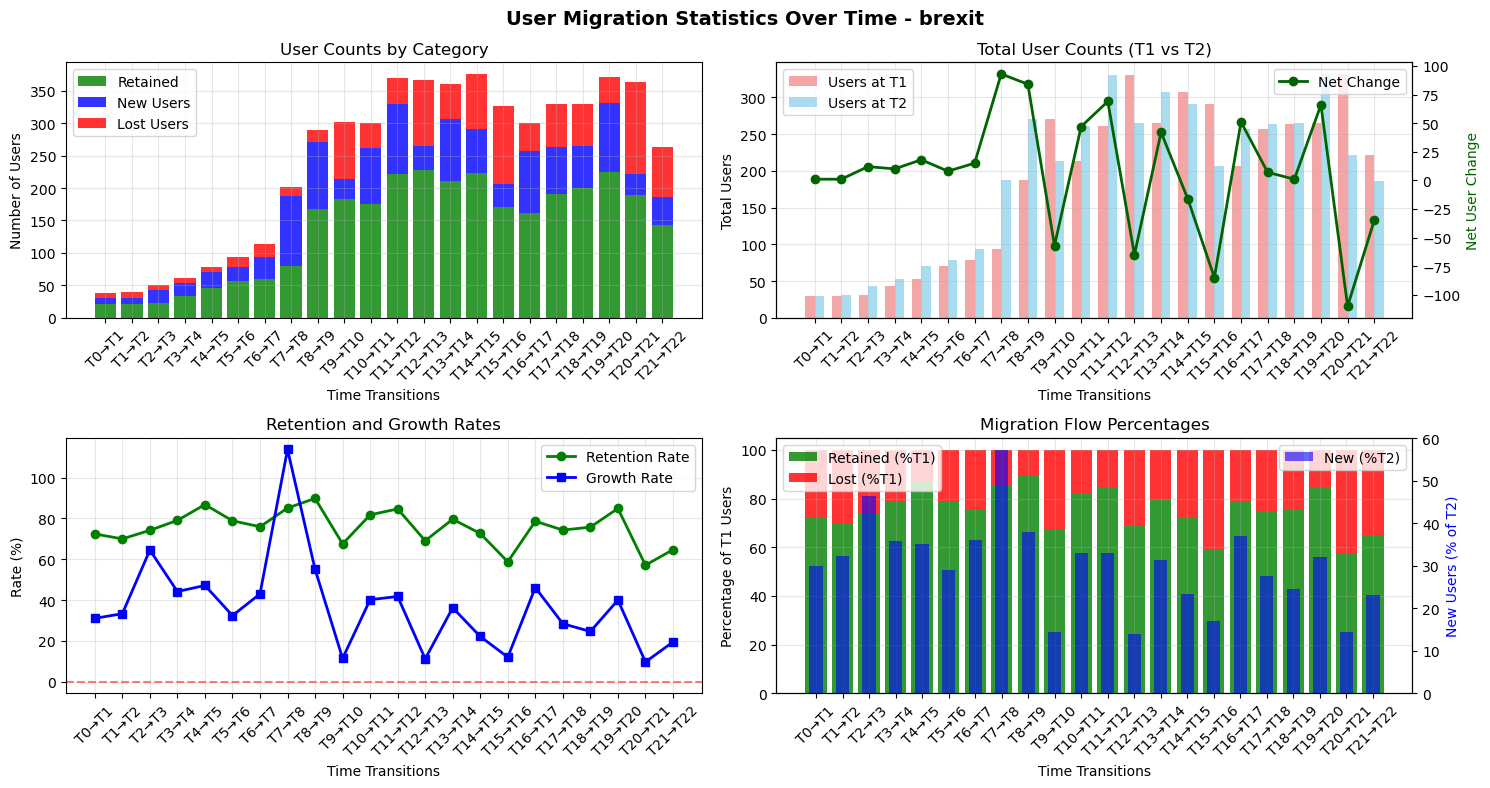


USER MIGRATION SUMMARY - brexit

Transition T0 → T1:
  Total users T0: 29
  Total users T1: 30
  Retained: 21 (72.4%)
  New: 9 (31.0%)
  Lost: 8
  Net change: +1

Transition T1 → T2:
  Total users T1: 30
  Total users T2: 31
  Retained: 21 (70.0%)
  New: 10 (33.3%)
  Lost: 9
  Net change: +1

Transition T2 → T3:
  Total users T2: 31
  Total users T3: 43
  Retained: 23 (74.2%)
  New: 20 (64.5%)
  Lost: 8
  Net change: +12

Transition T3 → T4:
  Total users T3: 43
  Total users T4: 53
  Retained: 34 (79.1%)
  New: 19 (44.2%)
  Lost: 9
  Net change: +10

Transition T4 → T5:
  Total users T4: 53
  Total users T5: 71
  Retained: 46 (86.8%)
  New: 25 (47.2%)
  Lost: 7
  Net change: +18

Transition T5 → T6:
  Total users T5: 71
  Total users T6: 79
  Retained: 56 (78.9%)
  New: 23 (32.4%)
  Lost: 15
  Net change: +8

Transition T6 → T7:
  Total users T6: 79
  Total users T7: 94
  Retained: 60 (75.9%)
  New: 34 (43.0%)
  Lost: 19
  Net change: +15

Transition T7 → T8:
  Total users T7: 94
  T

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_user_migration_stats(evolution_data, subreddit_name=None, figsize=(15, 8)):
    """
    Create bar/line plots to visualize user migration statistics over time for a single subreddit.
    
    Args:
        evolution_data: dict containing evolution analysis results from analyzer.analyze_evolution()
        subreddit_name: optional name for the subreddit (for title)
        figsize: tuple for figure size
    """
    if evolution_data is None:
        print("No evolution data provided")
        return
    
    # Extract data
    ts_pairs = evolution_data['ts_pairs']
    migration_stats = evolution_data['migration_stats']
    
    if not ts_pairs:
        print("No timestep pairs found")
        return
    
    # Prepare data for plotting
    transitions = [f"T{t1}→T{t2}" for t1, t2 in ts_pairs]
    
    # Extract migration statistics
    total_t1 = [stats['total_t1'] for stats in migration_stats]
    total_t2 = [stats['total_t2'] for stats in migration_stats]
    retained = [stats['retained'] for stats in migration_stats]
    new_users = [stats['new'] for stats in migration_stats]
    lost_users = [stats['lost'] for stats in migration_stats]
    retention_rates = [stats['retention_rate'] * 100 for stats in migration_stats]  # Convert to percentage
    growth_rates = [stats['growth_rate'] * 100 for stats in migration_stats]  # Convert to percentage
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'User Migration Statistics Over Time{f" - {subreddit_name}" if subreddit_name else ""}', 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: Absolute User Counts (Stacked Bar)
    x = np.arange(len(transitions))
    width = 0.35
    
    ax1.bar(x, retained, label='Retained', alpha=0.8, color='green')
    ax1.bar(x, new_users, bottom=retained, label='New Users', alpha=0.8, color='blue')
    ax1.bar(x, lost_users, bottom=[r + n for r, n in zip(retained, new_users)], 
            label='Lost Users', alpha=0.8, color='red')
    
    ax1.set_xlabel('Time Transitions')
    ax1.set_ylabel('Number of Users')
    ax1.set_title('User Counts by Category')
    ax1.set_xticks(x)
    ax1.set_xticklabels(transitions, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total Users Comparison (Line + Bar)
    ax2_bar = ax2
    ax2_line = ax2.twinx()
    
    bars = ax2_bar.bar(x, total_t1, width, label='Users at T1', alpha=0.7, color='lightcoral')
    ax2_bar.bar(x + width, total_t2, width, label='Users at T2', alpha=0.7, color='skyblue')
    
    # Add line showing the difference
    user_diff = [t2 - t1 for t1, t2 in zip(total_t1, total_t2)]
    line = ax2_line.plot(x + width/2, user_diff, 'o-', color='darkgreen', linewidth=2, 
                         markersize=6, label='Net Change')
    
    ax2_bar.set_xlabel('Time Transitions')
    ax2_bar.set_ylabel('Total Users', color='black')
    ax2_line.set_ylabel('Net User Change', color='darkgreen')
    ax2_bar.set_title('Total User Counts (T1 vs T2)')
    ax2_bar.set_xticks(x + width/2)
    ax2_bar.set_xticklabels(transitions, rotation=45)
    
    # Combine legends
    bars_legend = ax2_bar.legend(loc='upper left')
    line_legend = ax2_line.legend(loc='upper right')
    ax2_bar.grid(True, alpha=0.3)
    
    # Plot 3: Retention and Growth Rates (Line Plot)
    ax3.plot(x, retention_rates, 'o-', linewidth=2, markersize=6, label='Retention Rate', color='green')
    ax3.plot(x, growth_rates, 's-', linewidth=2, markersize=6, label='Growth Rate', color='blue')
    
    ax3.set_xlabel('Time Transitions')
    ax3.set_ylabel('Rate (%)')
    ax3.set_title('Retention and Growth Rates')
    ax3.set_xticks(x)
    ax3.set_xticklabels(transitions, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Zero line for reference
    
    # Plot 4: Migration Flow (Stacked Percentage)
    # Calculate percentages relative to T1 total
    retained_pct = [r/t1 * 100 for r, t1 in zip(retained, total_t1)]
    lost_pct = [l/t1 * 100 for l, t1 in zip(lost_users, total_t1)]
    # New users as percentage of T2 total
    new_pct = [n/t2 * 100 for n, t2 in zip(new_users, total_t2)]
    
    ax4.bar(x, retained_pct, label='Retained (%T1)', alpha=0.8, color='green')
    ax4.bar(x, lost_pct, bottom=retained_pct, label='Lost (%T1)', alpha=0.8, color='red')
    
    # Add new users as separate bars (different base)
    ax4_twin = ax4.twinx()
    ax4_twin.bar(x, new_pct, alpha=0.6, color='blue', width=0.5, label='New (%T2)')
    
    ax4.set_xlabel('Time Transitions')
    ax4.set_ylabel('Percentage of T1 Users', color='black')
    ax4_twin.set_ylabel('New Users (% of T2)', color='blue')
    ax4.set_title('Migration Flow Percentages')
    ax4.set_xticks(x)
    ax4.set_xticklabels(transitions, rotation=45)
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*50}")
    print(f"USER MIGRATION SUMMARY{f' - {subreddit_name}' if subreddit_name else ''}")
    print(f"{'='*50}")
    
    for i, (t1, t2) in enumerate(ts_pairs):
        print(f"\nTransition T{t1} → T{t2}:")
        print(f"  Total users T{t1}: {total_t1[i]:,}")
        print(f"  Total users T{t2}: {total_t2[i]:,}")
        print(f"  Retained: {retained[i]:,} ({retention_rates[i]:.1f}%)")
        print(f"  New: {new_users[i]:,} ({growth_rates[i]:.1f}%)")
        print(f"  Lost: {lost_users[i]:,}")
        print(f"  Net change: {total_t2[i] - total_t1[i]:+,}")


# Usage examples:
if __name__ == "__main__":
    # Analyze and plot for a single subreddit
    analyzer = CommunityEvolutionAnalyzer(verbose=False, matrix_display_limit=None)
    
    # Example for subreddit 0
    if 0 in processed_dict:
        evolution_data = analyzer.analyze_evolution(processed_dict[0])
        if evolution_data:
            subreddit_name = processed_dict[0][list(processed_dict[0].keys())[0]]['community_info']['subreddit']
            plot_user_migration_stats(evolution_data, subreddit_name)
    

C:\Users\vduch\AppData\Local\Temp\ipykernel_33520\4148637681.py:59: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.

C:\Users\vduch\AppData\Local\Temp\ipykernel_33520\4148637681.py:83: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.



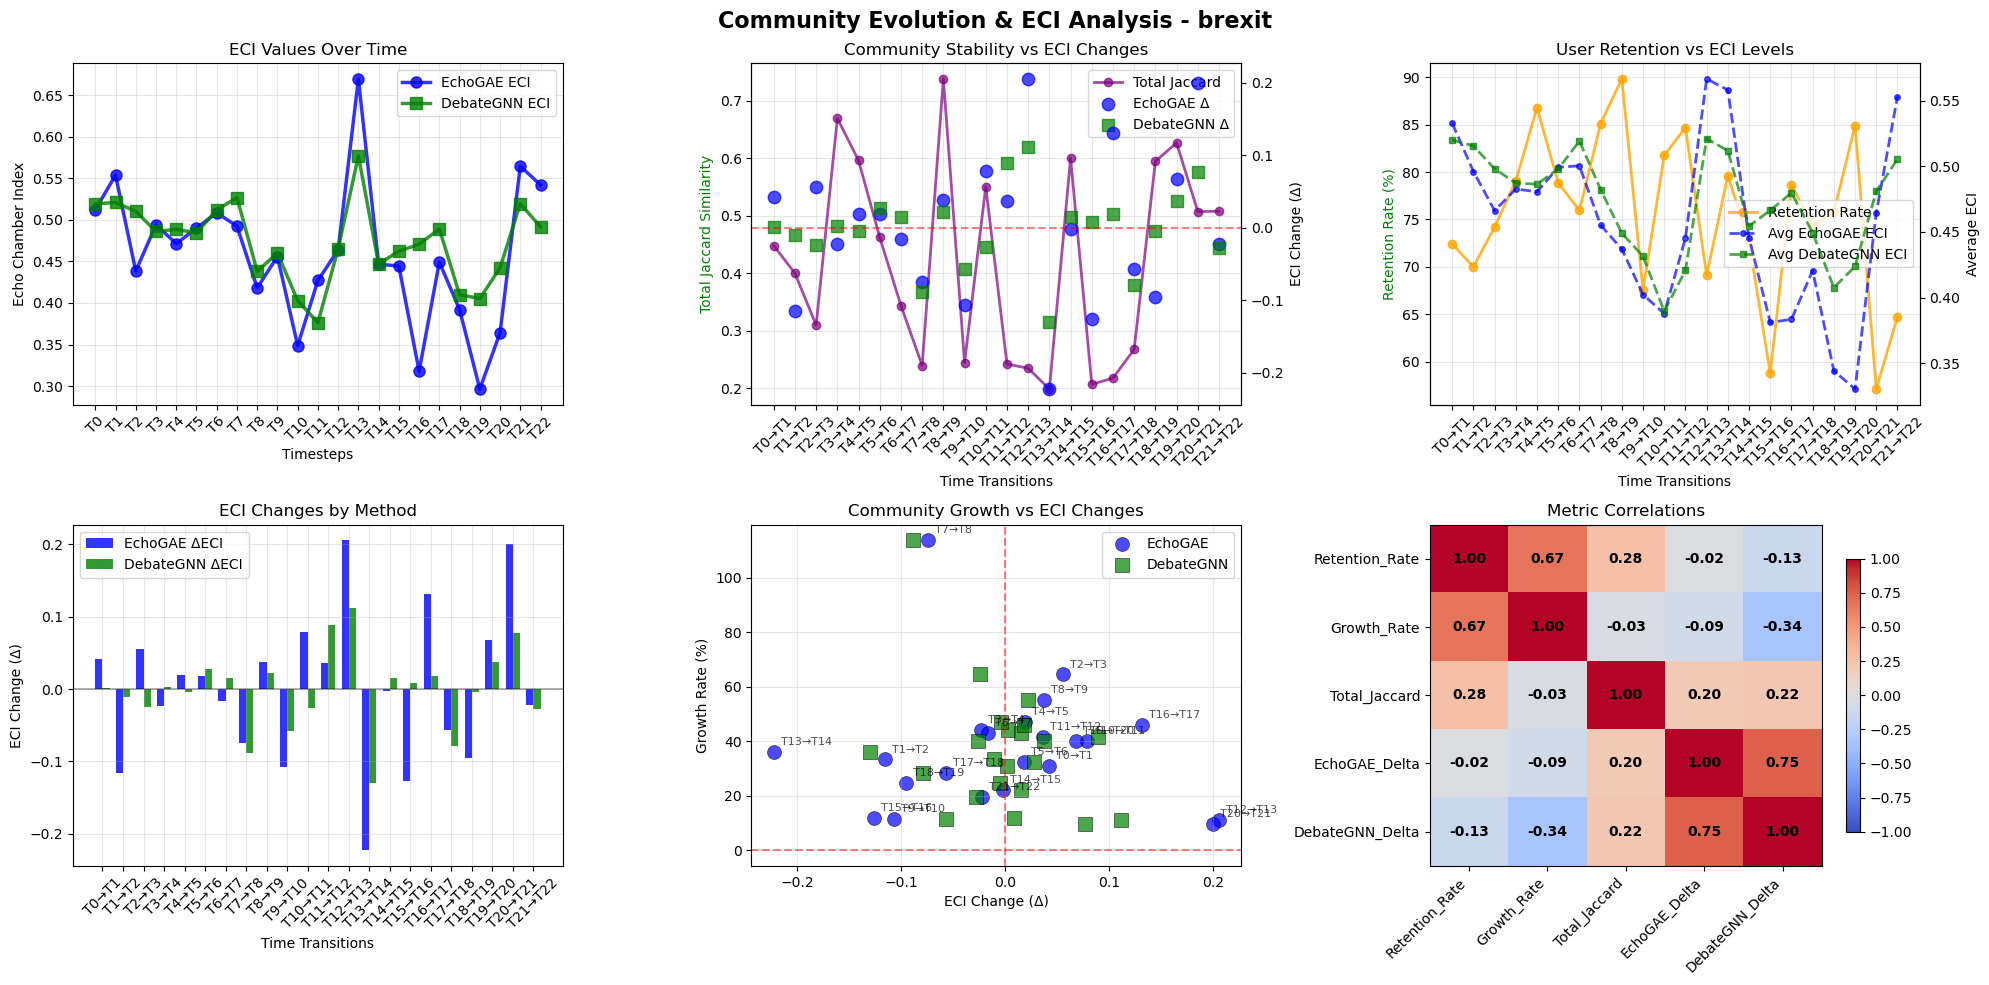


COMPREHENSIVE ANALYSIS SUMMARY - brexit

ECI EVOLUTION:
  T0: EchoGAE=0.5119, DebateGNN=0.5192
  T1: EchoGAE=0.5538, DebateGNN=0.5208
  T2: EchoGAE=0.4383, DebateGNN=0.5102
  T3: EchoGAE=0.4942, DebateGNN=0.4860
  T4: EchoGAE=0.4712, DebateGNN=0.4885
  T5: EchoGAE=0.4900, DebateGNN=0.4842
  T6: EchoGAE=0.5085, DebateGNN=0.5117
  T7: EchoGAE=0.4923, DebateGNN=0.5267
  T8: EchoGAE=0.4181, DebateGNN=0.4379
  T9: EchoGAE=0.4558, DebateGNN=0.4601
  T10: EchoGAE=0.3487, DebateGNN=0.4028
  T11: EchoGAE=0.4272, DebateGNN=0.3763
  T12: EchoGAE=0.4637, DebateGNN=0.4651
  T13: EchoGAE=0.6694, DebateGNN=0.5769
  T14: EchoGAE=0.4467, DebateGNN=0.4469
  T15: EchoGAE=0.4445, DebateGNN=0.4623
  T16: EchoGAE=0.3178, DebateGNN=0.4705
  T17: EchoGAE=0.4491, DebateGNN=0.4890
  T18: EchoGAE=0.3920, DebateGNN=0.4100
  T19: EchoGAE=0.2965, DebateGNN=0.4053
  T20: EchoGAE=0.3643, DebateGNN=0.4423
  T21: EchoGAE=0.5644, DebateGNN=0.5195
  T22: EchoGAE=0.5419, DebateGNN=0.4914

TRANSITION ANALYSIS:

Transition

In [16]:
def plot_combined_migration_and_eci(evolution_data, processed_dict_single_subreddit, subreddit_name=None, figsize=(20, 10)):
    """
    Create comprehensive plots combining user migration stats with ECI comparisons for EchoGAE and DebateGNN.
    
    Args:
        evolution_data: dict containing evolution analysis results from analyzer.analyze_evolution()
        processed_dict_single_subreddit: dict {timestep: data} for a single subreddit
        subreddit_name: optional name for the subreddit (for title)
        figsize: tuple for figure size
    """
    if evolution_data is None or not processed_dict_single_subreddit:
        print("No evolution data or processed data provided")
        return
    
    # Extract migration data
    ts_pairs = evolution_data['ts_pairs']
    migration_stats = evolution_data['migration_stats']
    transitions = [f"T{t1}→T{t2}" for t1, t2 in ts_pairs]
    
    # Extract ECI data from processed_dict
    timesteps = sorted(processed_dict_single_subreddit.keys())
    echogae_eci_values = [processed_dict_single_subreddit[ts]['echogae_eci'] for ts in timesteps]
    debgnn_eci_values = [processed_dict_single_subreddit[ts]['debgnn_eci'] for ts in timesteps]
    
    # Calculate ECI changes between timesteps (for transitions)
    echogae_eci_deltas = [echogae_eci_values[i+1] - echogae_eci_values[i] for i in range(len(echogae_eci_values)-1)]
    debgnn_eci_deltas = [debgnn_eci_values[i+1] - debgnn_eci_values[i] for i in range(len(debgnn_eci_values)-1)]
    
    # Extract migration statistics
    retention_rates = [stats['retention_rate'] * 100 for stats in migration_stats]
    growth_rates = [stats['growth_rate'] * 100 for stats in migration_stats]
    total_jaccards = evolution_data['total_jaccards']
    
    # Create subplots (2x3 layout)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Community Evolution & ECI Analysis{f" - {subreddit_name}" if subreddit_name else ""}', fontsize=16, fontweight='bold')
    
    x = np.arange(len(transitions))
    
    # Plot 1: ECI Values Over Time (Line Plot)
    timestep_labels = [f"T{ts}" for ts in timesteps]
    ax1.plot(timesteps, echogae_eci_values, 'o-', linewidth=2.5, markersize=8, 
             label='EchoGAE ECI', color='blue', alpha=0.8)
    ax1.plot(timesteps, debgnn_eci_values, 's-', linewidth=2.5, markersize=8, 
             label='DebateGNN ECI', color='green', alpha=0.8)
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Echo Chamber Index')
    ax1.set_title('ECI Values Over Time')
    ax1.set_xticks(timesteps)
    ax1.set_xticklabels(timestep_labels, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ECI Changes vs Jaccard Similarity (Scatter + Line)
    ax2_line = ax2
    ax2_scatter = ax2.twinx()
    
    # Line plot for total Jaccard similarity
    line = ax2_line.plot(x, total_jaccards, 'g-', linewidth=2, marker='o', markersize=6, 
                         label='Total Jaccard', alpha=0.7, color='purple')
    
    # Scatter plot for ECI changes
    scatter1 = ax2_scatter.scatter(x, echogae_eci_deltas, c='blue', s=80, alpha=0.7, 
                                   marker='o', label='EchoGAE Δ')
    scatter2 = ax2_scatter.scatter(x, debgnn_eci_deltas, c='green', s=80, alpha=0.7, 
                                   marker='s', label='DebateGNN Δ')
    
    ax2_line.set_xlabel('Time Transitions')
    ax2_line.set_ylabel('Total Jaccard Similarity', color='green')
    ax2_scatter.set_ylabel('ECI Change (Δ)', color='black')
    ax2_line.set_title('Community Stability vs ECI Changes')
    ax2_line.set_xticks(x)
    ax2_line.set_xticklabels(transitions, rotation=45)
    ax2_scatter.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Combine legends
    lines1, labels1 = ax2_line.get_legend_handles_labels()
    lines2, labels2 = ax2_scatter.get_legend_handles_labels()
    ax2_line.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax2_line.grid(True, alpha=0.3)
    
    # Plot 3: User Retention vs ECI (Comparison)
    ax3.plot(x, retention_rates, 'g-o',  color="orange", linewidth=2, markersize=6, label='Retention Rate', alpha=0.8)
    
    # Secondary y-axis for average ECI during transition
    ax3_eci = ax3.twinx()
    avg_echogae_eci = [(echogae_eci_values[i] + echogae_eci_values[i+1])/2 for i in range(len(echogae_eci_values)-1)]
    avg_debgnn_eci = [(debgnn_eci_values[i] + debgnn_eci_values[i+1])/2 for i in range(len(debgnn_eci_values)-1)]
    
    ax3_eci.plot(x, avg_echogae_eci, 'blue', linestyle='--', linewidth=2, 
                 marker='o', markersize=4, label='Avg EchoGAE ECI', alpha=0.7)
    ax3_eci.plot(x, avg_debgnn_eci, 'green', linestyle='--', linewidth=2,
                 marker='s', markersize=4, label='Avg DebateGNN ECI', alpha=0.7)
    
    ax3.set_xlabel('Time Transitions')
    ax3.set_ylabel('Retention Rate (%)', color='green')
    ax3_eci.set_ylabel('Average ECI', color='black')
    ax3.set_title('User Retention vs ECI Levels')
    ax3.set_xticks(x)
    ax3.set_xticklabels(transitions, rotation=45)
    
    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_eci.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ECI Delta Comparison (Bar Chart)
    width = 0.35
    ax4.bar(x - width/2, echogae_eci_deltas, width, label='EchoGAE ΔECI', 
            alpha=0.8, color='blue')
    ax4.bar(x + width/2, debgnn_eci_deltas, width, label='DebateGNN ΔECI', 
            alpha=0.8, color='green')

    ax4.set_xlabel('Time Transitions')
    ax4.set_ylabel('ECI Change (Δ)')
    ax4.set_title('ECI Changes by Method')
    ax4.set_xticks(x)
    ax4.set_xticklabels(transitions, rotation=45)
    ax4.legend()
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Growth Rate vs ECI Changes (Scatter)
    ax5.scatter(echogae_eci_deltas, growth_rates, c='blue', s=100, alpha=0.7, 
                marker='o', label='EchoGAE', edgecolors='black', linewidth=0.5)
    ax5.scatter(debgnn_eci_deltas, growth_rates, c='green', s=100, alpha=0.7, 
                marker='s', label='DebateGNN', edgecolors='black', linewidth=0.5)
    
    # Add transition labels to points
    for i, transition in enumerate(transitions):
        ax5.annotate(transition, (echogae_eci_deltas[i], growth_rates[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    ax5.set_xlabel('ECI Change (Δ)')
    ax5.set_ylabel('Growth Rate (%)')
    ax5.set_title('Community Growth vs ECI Changes')
    ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Method Comparison Summary (Heatmap-style)
    # Create correlation matrix between metrics
    import pandas as pd
    from matplotlib.colors import LinearSegmentedColormap
    
    # Prepare data for correlation analysis
    metrics_df = pd.DataFrame({
        'Retention_Rate': retention_rates,
        'Growth_Rate': growth_rates,
        'Total_Jaccard': total_jaccards,
        'EchoGAE_Delta': echogae_eci_deltas,
        'DebateGNN_Delta': debgnn_eci_deltas
    })
    
    correlation_matrix = metrics_df.corr()
    
    # Create heatmap
    im = ax6.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

    # Set ticks and labels
    ax6.set_xticks(range(len(correlation_matrix.columns)))
    ax6.set_yticks(range(len(correlation_matrix.columns)))
    ax6.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax6.set_yticklabels(correlation_matrix.columns)
    ax6.set_title('Metric Correlations')
    
    # Add correlation values as text
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text = ax6.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax6, shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE ANALYSIS SUMMARY{f' - {subreddit_name}' if subreddit_name else ''}")
    print(f"{'='*70}")
    
    print(f"\nECI EVOLUTION:")
    for i, ts in enumerate(timesteps):
        print(f"  T{ts}: EchoGAE={echogae_eci_values[i]:.4f}, DebateGNN={debgnn_eci_values[i]:.4f}")
    
    print(f"\nTRANSITION ANALYSIS:")
    for i, (t1, t2) in enumerate(ts_pairs):
        print(f"\nTransition T{t1} → T{t2}:")
        print(f"  User Retention: {retention_rates[i]:.1f}%")
        print(f"  User Growth: {growth_rates[i]:.1f}%")
        print(f"  Total Jaccard: {total_jaccards[i]:.3f}")
        print(f"  EchoGAE ΔECI: {echogae_eci_deltas[i]:+.4f}")
        print(f"  DebateGNN ΔECI: {debgnn_eci_deltas[i]:+.4f}")
    
    print(f"\nCORRELATION INSIGHTS:")
    print(f"  EchoGAE ΔECI vs Retention: {correlation_matrix.loc['EchoGAE_Delta', 'Retention_Rate']:.3f}")
    print(f"  DebateGNN ΔECI vs Retention: {correlation_matrix.loc['DebateGNN_Delta', 'Retention_Rate']:.3f}")
    print(f"  EchoGAE ΔECI vs Jaccard: {correlation_matrix.loc['EchoGAE_Delta', 'Total_Jaccard']:.3f}")
    print(f"  DebateGNN ΔECI vs Jaccard: {correlation_matrix.loc['DebateGNN_Delta', 'Total_Jaccard']:.3f}")


# Usage example:
if __name__ == "__main__":
    # Analyze and plot for a single subreddit with ECI comparison
    analyzer = CommunityEvolutionAnalyzer(verbose=False, matrix_display_limit=None)
    
    # Example for subreddit 0
    if 0 in processed_dict:
        evolution_data = analyzer.analyze_evolution(processed_dict[0])
        if evolution_data:
            subreddit_name = processed_dict[0][list(processed_dict[0].keys())[0]]['community_info']['subreddit']
            plot_combined_migration_and_eci(evolution_data, processed_dict[0], subreddit_name)

In [17]:
import colorsys

def _hex_to_rgb(hex_color: str):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def _rgb_to_hex(rgb):
    return '#{:02X}{:02X}{:02X}'.format(*rgb)

def _lighten(hex_color: str, amount: float = 0.15) -> str:
    # amount in [0, 1]; positive = lighten
    r, g, b = _hex_to_rgb(hex_color)
    r_f, g_f, b_f = [c/255.0 for c in (r, g, b)]
    h, l, s = colorsys.rgb_to_hls(r_f, g_f, b_f)
    l = min(1.0, l + amount)
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return _rgb_to_hex((int(round(r2*255)), int(round(g2*255)), int(round(b2*255))))

def _shift_hue(hex_color: str, degrees: float) -> str:
    # shift hue by degrees in HLS space
    r, g, b = _hex_to_rgb(hex_color)
    r_f, g_f, b_f = [c/255.0 for c in (r, g, b)]
    h, l, s = colorsys.rgb_to_hls(r_f, g_f, b_f)
    h = (h + degrees/360.0) % 1.0
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return _rgb_to_hex((int(round(r2*255)), int(round(g2*255)), int(round(b2*255))))

def _get_palette(name: str = "tableau20"):
    if name == "glasbey32":
        # 32 high-contrast colors (subset of Glasbey)
        return [
            "#7F3C8D","#11A579","#3969AC","#F2B701","#E73F74","#80BA5A","#E68310","#008695",
            "#CF1C90","#F97B72","#4B4B8F","#A5AA99","#9C179E","#3E4A89","#79AF97","#F0C808",
            "#F564E3","#5C53A5","#1A85FF","#D41159","#00A08A","#F5793A","#B8B0AC","#6A3D9A",
            "#4E79A7","#59A14F","#E15759","#F28E2B","#EDC948","#B07AA1","#FF9DA7","#9C755F",
        ]
    # Default: extended Tableau-like palette (20)
    return [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
        "#4e79a7","#f28e2b","#e15759","#76b7b2","#59a14f",
        "#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"
    ]

def build_lineage_colors(processed_dict_single_subreddit,
                         evolution_data,
                         mode: str = "hungarian",          # "hungarian" | "max_intersection"
                         min_jaccard_parent: float = 0.05,
                         base_palette=None,
                         split_strategy: str = "hue_shift"  # "lighten" | "hue_shift" | "new_hues"
                         ) -> dict:
    """
    Returns dict mapping node_key 'ts_commId' -> hex color with lineage continuity.
    split_strategy:
      - lighten: keep parent hue, lighten siblings (old behavior)
      - hue_shift: small hue shifts for siblings (more variety, keeps lineage vibe)
      - new_hues: largest child keeps parent hue, others get fresh palette hues
    """
    if base_palette is None:
        base_palette = _get_palette("glasbey32")

    timesteps = sorted(processed_dict_single_subreddit.keys())
    if not timesteps:
        return {}

    # Assign seed colors at first timestep by community size (stable ordering)
    first_ts = timesteps[0]
    comm_nodes_t0 = processed_dict_single_subreddit[first_ts]['community_info']['comm_nodes']
    t0_order = sorted(comm_nodes_t0.keys(), key=lambda c: -len(comm_nodes_t0[c]))
    color_map = {}
    lineage_seed = {}  # (ts, comm) -> base_hex
    next_color_idx = 0

    for cid in t0_order:
        base_col = base_palette[next_color_idx % len(base_palette)]
        lineage_seed[(first_ts, cid)] = base_col
        color_map[f"{first_ts}_{cid}"] = base_col
        next_color_idx += 1

    # Walk forward in time
    hungarian = evolution_data.get('hungarian_matches', [])

    for idx in range(len(timesteps)-1):
        t1, t2 = timesteps[idx], timesteps[idx+1]
        comms_t1 = processed_dict_single_subreddit[t1]['community_info']['comm_nodes']
        comms_t2 = processed_dict_single_subreddit[t2]['community_info']['comm_nodes']

        # Decide parent for each t2 community
        parent_of_child = {}  # child_comm -> (t1_comm or None)
        if mode == "hungarian" and idx < len(hungarian):
            for m in hungarian[idx]:
                if m['assignment_type'] == 'matched' and m['jaccard'] >= min_jaccard_parent:
                    parent_of_child[m['t2_comm']] = m['t1_comm']
        # Fallback: best-intersection parent
        for child in comms_t2.keys():
            if child in parent_of_child:
                continue
            best_parent, best_inter, best_j = None, -1, 0.0
            c_users = set(comms_t2[child])
            for p in comms_t1.keys():
                p_users = set(comms_t1[p])
                inter = len(c_users & p_users)
                if inter == 0:
                    continue
                union = len(c_users | p_users)
                j = inter/union if union else 0.0
                if inter > best_inter or (inter == best_inter and j > best_j):
                    best_parent, best_inter, best_j = p, inter, j
            parent_of_child[child] = best_parent if (best_parent is not None and best_j >= min_jaccard_parent) else None

        # Group children by parent
        children_by_parent = {}
        for child, parent in parent_of_child.items():
            children_by_parent.setdefault(parent, []).append(child)

        # Assign colors
        for parent, children in children_by_parent.items():
            children_sorted = sorted(children, key=lambda c: -len(comms_t2[c]))
            if parent is None:
                # New lineage; assign fresh base color per child
                for child in children_sorted:
                    base_col = base_palette[next_color_idx % len(base_palette)]
                    next_color_idx += 1
                    lineage_seed[(t2, child)] = base_col
                    color_map[f"{t2}_{child}"] = base_col
            else:
                parent_key = (t1, parent)
                base_col = lineage_seed.get(parent_key)
                if base_col is None:
                    base_col = base_palette[next_color_idx % len(base_palette)]
                    next_color_idx += 1
                    lineage_seed[parent_key] = base_col

                n = len(children_sorted)
                for idx_c, child in enumerate(children_sorted):
                    if n == 1:
                        child_col = base_col
                    else:
                        if split_strategy == "lighten":
                            amt = min(0.36, 0.12 * idx_c)
                            child_col = _lighten(base_col, amt)
                        elif split_strategy == "hue_shift":
                            # Shift hue ±8°, ±16°, ... and slight lighten
                            shift_deg = (idx_c % 2 and 1 or -1) * (8 * ((idx_c+1)//2))
                            child_col = _lighten(_shift_hue(base_col, shift_deg), 0.10)
                        else:  # "new_hues"
                            if idx_c == 0:
                                child_col = base_col
                            else:
                                child_col = base_palette[next_color_idx % len(base_palette)]
                                next_color_idx += 1
                        # clamp: ensure valid hex already
                    lineage_seed[(t2, child)] = base_col  # propagate base for next step
                    color_map[f"{t2}_{child}"] = child_col

    return color_map

def _gen_extra_colors(n: int):
    cols = []
    for i in range(max(1, n)):
        h = (i / max(1, n)) % 1.0
        r, g, b = colorsys.hls_to_rgb(h, 0.55, 0.75)
        cols.append(_rgb_to_hex((int(round(r*255)), int(round(g*255)), int(round(b*255)))))
    return cols

def build_unique_node_colors(processed_dict_single_subreddit, palette_name: str = "glasbey32") -> dict:
    timesteps = sorted(processed_dict_single_subreddit.keys())
    total_nodes = sum(len(processed_dict_single_subreddit[ts]['community_info']['comm_nodes']) for ts in timesteps)
    base = _get_palette(palette_name)
    colors = base[:] if total_nodes <= len(base) else base + _gen_extra_colors(total_nodes - len(base))

    color_map = {}
    idx = 0
    for ts in timesteps:
        comm_nodes = processed_dict_single_subreddit[ts]['community_info']['comm_nodes']
        for comm_id in sorted(comm_nodes.keys()):
            color_map[f"{ts}_{comm_id}"] = colors[idx % len(colors)]
            idx += 1
    return color_map

In [18]:
import plotly.graph_objects as go
import numpy as np
from collections import defaultdict

def create_community_sankey(evolution_data, processed_dict_single_subreddit, subreddit_name=None, color_mode: str = "lineage"):
    """
    Create a Sankey diagram showing Hungarian algorithm optimal community matches with Jaccard values.
    """
    if evolution_data is None or not processed_dict_single_subreddit:
        print("No evolution data or processed data provided")
        return
    
    timesteps = sorted(processed_dict_single_subreddit.keys())
    ts_pairs = evolution_data['ts_pairs']
    hungarian_matches = evolution_data['hungarian_matches']
    
    if color_mode == "unique":
        node_color_map = build_unique_node_colors(processed_dict_single_subreddit)
    else:
        node_color_map = build_lineage_colors(
            processed_dict_single_subreddit,
            evolution_data,
            mode="hungarian",
            min_jaccard_parent=0.05,
            split_strategy="new_hues"
        )

    # Create nodes
    all_nodes, node_colors, node_indices = [], [], {}
    for i, ts in enumerate(timesteps):
        comm_nodes = processed_dict_single_subreddit[ts]['community_info']['comm_nodes']
        for comm_id in sorted(comm_nodes.keys()):
            node_label = f"T{ts}_C{comm_id} ({len(comm_nodes[comm_id])})"
            node_key = f"{ts}_{comm_id}"
            all_nodes.append(node_label)
            node_indices[node_key] = len(all_nodes) - 1
            node_colors.append(node_color_map.get(node_key, "#999999"))


    # Create nodes (communities at each timestep)
    all_nodes = []
    node_colors = []
    node_indices = {}
    color_map = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
    
    # Add nodes for each timestep
    for i, ts in enumerate(timesteps):
        community_info = processed_dict_single_subreddit[ts]['community_info']
        comm_nodes = community_info['comm_nodes']
        
        for comm_id in sorted(comm_nodes.keys()):
            node_size = len(comm_nodes[comm_id])
            node_label = f"T{ts}_C{comm_id} ({node_size})"
            node_key = f"{ts}_{comm_id}"
            
            all_nodes.append(node_label)
            node_indices[node_key] = len(all_nodes) - 1
            # USE lineage color
            node_colors.append(node_color_map.get(node_key, "#999999"))
    
    # Create flows from Hungarian matches
    sources = []
    targets = []
    values = []
    jaccard_scores = []
    match_details = []
    
    print("Creating Hungarian Algorithm Sankey diagram...")
    
    for transition_idx, (t1, t2) in enumerate(ts_pairs):
        transition_matches = hungarian_matches[transition_idx]
        print(f"\nTransition T{t1} → T{t2} (Hungarian Optimal Matches):")
        
        matched_flows = [m for m in transition_matches if m['assignment_type'] == 'matched' and m['jaccard'] > 0]
        
        for match in matched_flows:
            t1_comm = match['t1_comm']
            t2_comm = match['t2_comm']
            jaccard = match['jaccard']
            t1_size = match['t1_size']
            t2_size = match['t2_size']
            
            # Calculate actual flow value (intersection of users)
            t1_communities = processed_dict_single_subreddit[t1]['community_info']['comm_nodes']
            t2_communities = processed_dict_single_subreddit[t2]['community_info']['comm_nodes']
            
            t1_users = set(t1_communities[t1_comm])
            t2_users = set(t2_communities[t2_comm])
            flow_value = len(t1_users.intersection(t2_users))
            
            source_key = f"{t1}_{t1_comm}"
            target_key = f"{t2}_{t2_comm}"
            
            if source_key in node_indices and target_key in node_indices:
                sources.append(node_indices[source_key])
                targets.append(node_indices[target_key])
                values.append(flow_value)
                jaccard_scores.append(jaccard)
                
                match_details.append({
                    'transition': f"T{t1}→T{t2}",
                    't1_comm': t1_comm,
                    't2_comm': t2_comm,
                    'flow_value': flow_value,
                    'jaccard': jaccard,
                    't1_size': t1_size,
                    't2_size': t2_size
                })
                
                print(f"    C{t1_comm}→C{t2_comm}: {flow_value} users (J={jaccard:.3f})")
    
    # Create enhanced link colors based on Jaccard similarity
    link_colors = []
    for jaccard in jaccard_scores:
        if jaccard >= 0.5:
            link_colors.append("rgba(0, 128, 0, 0.8)")  # Strong green
        elif jaccard >= 0.3:
            link_colors.append("rgba(255, 165, 0, 0.7)")  # Orange
        elif jaccard >= 0.1:
            link_colors.append("rgba(255, 255, 0, 0.6)")  # Yellow
        else:
            link_colors.append("rgba(128, 128, 128, 0.4)")  # Gray
    
    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            hovertemplate='%{source.label} → %{target.label}<br>' +
                         'Flow: %{value} users<br>' +
                         'Jaccard: %{customdata:.3f}<br>' +
                         'Assignment: Hungarian Optimal<extra></extra>',
            customdata=jaccard_scores
        )
    ))

    title = f"{subreddit_name}'s Community Flow (Hungarian Best Matches)"
    subtitle = "Link Colors: 🟢 Strong (J≥0.5) 🟠 Medium (0.3≤J<0.5) 🟡 Low (0.1≤J<0.3) ⚫ Very Low (J<0.1)"
    
    annot_node_colors = "Lineage (siblings share hue)" if color_mode != "unique" else "Unique per community"
    fig.update_layout(
        title_text=f"{title}<br><sub>{subtitle}</sub>",
        font_size=12,
        height=700,
        width=1500,  # wider canvas
        margin=dict(l=50, r=50, t=100, b=50),
        annotations=[
            dict(
                text=f"Shows optimal 1-to-1 community assignments maximizing total Jaccard similarity",
                showarrow=False, xref="paper", yref="paper", x=0.5, y=-0.1, xanchor='center', yanchor='top',
                font=dict(size=10, color="gray")
            ),
            dict(
                text=f"Node Colors = {annot_node_colors}",
                showarrow=False, xref="paper", yref="paper", x=0.5, y=-0.16, xanchor='center', yanchor='top',
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    fig.show()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"HUNGARIAN MATCHES SUMMARY{f' - {subreddit_name}' if subreddit_name else ''}")
    print(f"{'='*70}")
    print(f"Total optimal matches: {len(sources)}")
    print(f"Total users in optimal flows: {sum(values)}")
    print(f"Average Jaccard similarity: {np.mean(jaccard_scores):.3f}")
    
    return match_details


def create_all_flows_sankey(evolution_data, processed_dict_single_subreddit, 
                           min_flow_threshold=3, min_jaccard_threshold=0.01, 
                           subreddit_name=None, color_mode: str = "lineage"):
    """Create a Sankey diagram showing ALL significant user flows between communities"""
    if evolution_data is None or not processed_dict_single_subreddit:
        print("No evolution data or processed data provided")
        return
    
    timesteps = sorted(processed_dict_single_subreddit.keys())
    ts_pairs = evolution_data['ts_pairs']
    
    if color_mode == "unique":
        node_color_map = build_unique_node_colors(processed_dict_single_subreddit)
    else:
        node_color_map = build_lineage_colors(
            processed_dict_single_subreddit,
            evolution_data,
            mode="max_intersection",
            min_jaccard_parent=max(0.05, min_jaccard_threshold),
            split_strategy="new_hues"
        )

    # Create nodes
    all_nodes, node_colors, node_indices, node_sizes = [], [], {}, []
    for i, ts in enumerate(timesteps):
        comm_nodes = processed_dict_single_subreddit[ts]['community_info']['comm_nodes']
        for comm_id in sorted(comm_nodes.keys()):
            node_label = f"T{ts}_C{comm_id} ({len(comm_nodes[comm_id])})"
            node_key = f"{ts}_{comm_id}"
            all_nodes.append(node_label)
            node_indices[node_key] = len(all_nodes) - 1
            node_sizes.append(len(comm_nodes[comm_id]))
            node_colors.append(node_color_map.get(node_key, "#999999"))

    # Create nodes (communities at each timestep)
    all_nodes = []
    node_colors = []
    node_indices = {}
    node_sizes = []
    color_map = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
    
    # Add nodes for each timestep
    for i, ts in enumerate(timesteps):
        community_info = processed_dict_single_subreddit[ts]['community_info']
        comm_nodes = community_info['comm_nodes']
        
        for comm_id in sorted(comm_nodes.keys()):
            node_size = len(comm_nodes[comm_id])
            node_label = f"T{ts}_C{comm_id} ({node_size})"
            node_key = f"{ts}_{comm_id}"
            
            all_nodes.append(node_label)
            node_indices[node_key] = len(all_nodes) - 1
            node_sizes.append(node_size)
            # USE lineage color
            node_colors.append(node_color_map.get(node_key, "#999999"))
    
    # Create ALL significant flows (not just Hungarian matches)
    sources = []
    targets = []
    values = []
    jaccard_scores = []
    flow_details = []
    
    print(f"Analyzing ALL user flows with thresholds:")
    print(f"  + Minimum flow: {min_flow_threshold} users")
    print(f"  + Minimum Jaccard similarity: {min_jaccard_threshold:.3f}")
    
    total_flows_found = 0
    total_flows_filtered = 0
    
    for transition_idx, (t1, t2) in enumerate(ts_pairs):
        print(f"\nTransition T{t1} → T{t2}:")
        
        # Get all communities for both timesteps
        t1_communities = processed_dict_single_subreddit[t1]['community_info']['comm_nodes']
        t2_communities = processed_dict_single_subreddit[t2]['community_info']['comm_nodes']
        
        transition_flows = []
        transition_filtered = 0
        
        # Check ALL community pairs for flows
        for t1_comm, t1_users in t1_communities.items():
            for t2_comm, t2_users in t2_communities.items():
                # Calculate actual user intersection
                t1_user_set = set(t1_users)
                t2_user_set = set(t2_users)
                flow_value = len(t1_user_set.intersection(t2_user_set))
                
                # Calculate Jaccard similarity
                union_size = len(t1_user_set.union(t2_user_set))
                jaccard = flow_value / union_size if union_size > 0 else 0.0
                
                total_flows_found += 1
                
                # Check if flow meets thresholds
                if flow_value >= min_flow_threshold and jaccard >= min_jaccard_threshold:
                    source_key = f"{t1}_{t1_comm}"
                    target_key = f"{t2}_{t2_comm}"
                    
                    if source_key in node_indices and target_key in node_indices:
                        sources.append(node_indices[source_key])
                        targets.append(node_indices[target_key])
                        values.append(flow_value)
                        jaccard_scores.append(jaccard)
                        
                        flow_details.append({
                            'transition': f"T{t1}→T{t2}",
                            't1_comm': t1_comm,
                            't2_comm': t2_comm,
                            'flow_value': flow_value,
                            'jaccard': jaccard,
                            't1_size': len(t1_users),
                            't2_size': len(t2_users)
                        })
                        
                        transition_flows.append((t1_comm, t2_comm, flow_value, jaccard))
                else:
                    transition_filtered += 1
        
        total_flows_filtered += transition_filtered
        
        # Print transition summary
        print(f"  Found {len(transition_flows)} significant flows (filtered out {transition_filtered}):")
        for t1_comm, t2_comm, flow, jacc in sorted(transition_flows, key=lambda x: x[2], reverse=True)[:10]:  # Show top 10
            strength = "Strong" if jacc >= 0.5 else "Medium" if jacc >= 0.3 else "Low" if jacc >= 0.1 else "Very Low"
            print(f"    C{t1_comm}→C{t2_comm}: {flow} users (J={jacc:.3f}, {strength})")
        if len(transition_flows) > 10:
            print(f"    ... and {len(transition_flows) - 10} more flows")
    
    # Create enhanced link colors based on Jaccard similarity
    link_colors = []
    significance_labels = []
    for jaccard in jaccard_scores:
        if jaccard >= 0.5:
            link_colors.append("rgba(0, 128, 0, 0.8)")  # Strong green for high similarity
            significance_labels.append("Strong")
        elif jaccard >= 0.3:
            link_colors.append("rgba(255, 165, 0, 0.7)")  # Orange for medium similarity
            significance_labels.append("Medium")
        elif jaccard >= 0.1:
            link_colors.append("rgba(255, 255, 0, 0.6)")  # Yellow for low similarity
            significance_labels.append("Low")
        else:
            link_colors.append("rgba(128, 128, 128, 0.4)")  # Gray for very low similarity
            significance_labels.append("Very Low")

    # Create the main Sankey diagram
    fig = go.Figure()

    # Add Sankey diagram
    fig.add_trace(go.Sankey(
        name="All Significant Flows",  # gives %{fullData.name} a meaningful value
        arrangement="snap",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            # Use customdata with two columns: [jaccard, significance_label]
            customdata=[[j, s] for j, s in zip(jaccard_scores, significance_labels)],
            hovertemplate='%{source.label} → %{target.label}<br>'
                            'Flow: %{value} users<br>'
                            'Jaccard: %{customdata[0]:.3f}<br>'
                            'Significance: %{customdata[1]}<extra></extra>',
        )
    ))
    
    # Create title and subtitle with filtering info
    title = f"{subreddit_name} - Community User Flows" if subreddit_name else ''
    subtitle = (f"Link Colors: 🟢 Strong (J≥0.5) 🟠 Medium (0.3≤J<0.5) 🟡 Low (0.1≤J<0.3) ⚫ Very Low (J<0.1)<br>"
                f"Filters: Min {min_flow_threshold} users, Min J≥{min_jaccard_threshold:.3f} | "
                f"Showing {len(sources)}/{total_flows_found} flows ({total_flows_filtered} filtered out)")
    
    annot_node_colors = "Lineage (siblings share hue)" if color_mode != "unique" else "Unique per community"
    fig.update_layout(
        title_text=f"{title}<br><sub>{subtitle}</sub>",
        font_size=12,
        height=700,
        width=1500,  # wider canvas
        margin=dict(l=50, r=50, t=120, b=50),  # Increased top margin for longer subtitle
        annotations=[
            dict(
                text=f"Link Width ∝ User Flow Size | Node Colors = {annot_node_colors} | Shows complete many-to-many community relationships",
                showarrow=False, xref="paper", yref="paper", x=0.5, y=-0.12, xanchor='center', yanchor='top',
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    fig.show()
    
    # Color distribution summary
    color_counts = {'Strong': 0, 'Medium': 0, 'Low': 0, 'Very Low': 0}
    for jaccard in jaccard_scores:
        if jaccard >= 0.5:
            color_counts['Strong'] += 1
        elif jaccard >= 0.3:
            color_counts['Medium'] += 1
        elif jaccard >= 0.1:
            color_counts['Low'] += 1
        else:
            color_counts['Very Low'] += 1
    
    # Print comprehensive summary
    print(f"\n{'='*70}")
    print(f"ALL FLOWS SANKEY SUMMARY{f' - {subreddit_name}' if subreddit_name else ''}")
    print(f"{'='*70}")
    print(f"FILTERING RESULTS:")
    print(f"  + Total possible flows: {total_flows_found:,}")
    print(f"  + Flows after filtering: {len(sources):,}")
    print(f"  + Filtered out: {total_flows_filtered:,} ({total_flows_filtered/total_flows_found*100:.1f}%)")
    print(f"  + Filter efficiency: {len(sources)/total_flows_found*100:.1f}% flows retained")
    
    print(f"\nFLOW STATISTICS:")
    print(f"  + Total nodes (communities): {len(all_nodes)}")
    print(f"  + Total links (significant flows): {len(sources)}")
    print(f"  + Total users in flows: {sum(values):,}")
    print(f"  + Average flow size: {np.mean(values):.1f} users")
    print(f"  + Average Jaccard similarity: {np.mean(jaccard_scores):.3f}")

    print(f"\nFLOW STRENGTH DISTRIBUTION:")
    for strength, count in color_counts.items():
        percentage = count / len(jaccard_scores) * 100 if jaccard_scores else 0
        print(f"  + {strength}: {count} flows ({percentage:.1f}%)")

    # Flow statistics by transition
    for t1, t2 in ts_pairs:
        transition_flows = [f for f in flow_details if f['transition'] == f"T{t1}→T{t2}"]
        total_flow = sum(f['flow_value'] for f in transition_flows)
        avg_jaccard = np.mean([f['jaccard'] for f in transition_flows]) if transition_flows else 0
        print(f"\n  T{t1} → T{t2}: {len(transition_flows)} flows, {total_flow:,} total users, avg Jaccard: {avg_jaccard:.3f}")
    
    return flow_details


def create_flow_comparison_sankey(evolution_data, processed_dict_single_subreddit, 
                                 min_flow_threshold=3, min_jaccard_threshold=0.01, 
                                 subreddit_name=None):
    """
    Create side-by-side comparison: Hungarian matches vs All significant flows
    """
    print("="*80)
    print("HUNGARIAN ALGORITHM MATCHES (Optimal Assignment)")
    print("="*80)
    
    # Hungarian-based Sankey with Jaccard values
    hungarian_details = create_community_sankey(evolution_data, processed_dict_single_subreddit, 
                                               f"{subreddit_name} - Hungarian Matches" if subreddit_name else "Hungarian Matches")
    
    print("\n" + "="*80)
    print("ALL SIGNIFICANT FLOWS (Complete Picture)")
    print("="*80)
    
    # All flows Sankey with enhanced filtering
    flow_details = create_all_flows_sankey(evolution_data, processed_dict_single_subreddit, 
                                          min_flow_threshold=min_flow_threshold,
                                          min_jaccard_threshold=min_jaccard_threshold,
                                          subreddit_name=f"{subreddit_name} - All Flows" if subreddit_name else "All Flows")
    
    # Comparison analysis
    print("\n" + "="*80)
    print("COMPARISON: Hungarian vs All Flows")
    print("="*80)
    
    if hungarian_details and flow_details:
        hungarian_total = sum(d['flow_value'] for d in hungarian_details)
        all_flows_total = sum(d['flow_value'] for d in flow_details)
        hungarian_avg_jaccard = np.mean([d['jaccard'] for d in hungarian_details])
        all_flows_avg_jaccard = np.mean([d['jaccard'] for d in flow_details])
        
        print(f"COVERAGE COMPARISON:")
        print(f"  + Hungarian flows: {len(hungarian_details)} flows, {hungarian_total:,} users")
        print(f"  + All significant flows: {len(flow_details)} flows, {all_flows_total:,} users")
        print(f"  + Coverage increase: {len(flow_details)/len(hungarian_details):.1f}x flows, {all_flows_total/hungarian_total:.1f}x users")
        
        print(f"\nQUALITY COMPARISON:")
        print(f"  + Hungarian avg Jaccard: {hungarian_avg_jaccard:.3f}")
        print(f"  + All flows avg Jaccard: {all_flows_avg_jaccard:.3f}")
        print(f"  + Quality difference: {hungarian_avg_jaccard - all_flows_avg_jaccard:+.3f}")
    
    return flow_details



In [19]:
# ...existing code...
if __name__ == "__main__":
    # Choose which Sankey to render
    USE_HUNGARIAN_ONLY = False  # set False to show all significant flows
    MIN_FLOW = 3               # only used for all-flows
    MIN_JACCARD = 0.05         # only used for all-flows

    if 0 in processed_dict and evolution_data:
        subreddit_name = processed_dict[0][list(processed_dict[0].keys())[0]]['community_info']['subreddit']
        print("="*80)
        print("SANKEY: HUNGARIAN" if USE_HUNGARIAN_ONLY else "SANKEY: ALL SIGNIFICANT FLOWS")
        print("="*80)

        if USE_HUNGARIAN_ONLY:
            _ = create_community_sankey(
                evolution_data=evolution_data,
                processed_dict_single_subreddit=processed_dict[0],
                subreddit_name=subreddit_name,
                # color_mode="unique"  # use unique colors
            )
        else:
            _ = create_all_flows_sankey(
                evolution_data=evolution_data,
                processed_dict_single_subreddit=processed_dict[0],
                min_flow_threshold=MIN_FLOW,
                min_jaccard_threshold=MIN_JACCARD,
                subreddit_name=subreddit_name,
                # color_mode="unique"  # use unique colors
            )
    else:
        print("No data available for Sankey.")

SANKEY: ALL SIGNIFICANT FLOWS
Analyzing ALL user flows with thresholds:
  + Minimum flow: 3 users
  + Minimum Jaccard similarity: 0.050

Transition T0 → T1:
  Found 2 significant flows (filtered out 4):
    C1→C0: 8 users (J=0.348, Medium)
    C0→C0: 7 users (J=0.259, Low)

Transition T1 → T2:
  Found 2 significant flows (filtered out 2):
    C0→C0: 14 users (J=0.400, Medium)
    C1→C0: 6 users (J=0.194, Low)

Transition T2 → T3:
  Found 3 significant flows (filtered out 5):
    C0→C0: 6 users (J=0.167, Low)
    C0→C1: 6 users (J=0.171, Low)
    C0→C2: 6 users (J=0.176, Low)

Transition T3 → T4:
  Found 7 significant flows (filtered out 9):
    C1→C0: 5 users (J=0.227, Low)
    C0→C1: 4 users (J=0.167, Low)
    C0→C2: 4 users (J=0.167, Low)
    C2→C0: 4 users (J=0.182, Low)
    C0→C3: 3 users (J=0.136, Low)
    C1→C1: 3 users (J=0.125, Low)
    C2→C3: 3 users (J=0.150, Low)

Transition T4 → T5:
  Found 9 significant flows (filtered out 3):
    C0→C2: 7 users (J=0.241, Low)
    C3→C0: 7


ALL FLOWS SANKEY SUMMARY - brexit
FILTERING RESULTS:
  + Total possible flows: 271
  + Flows after filtering: 119
  + Filtered out: 152 (56.1%)
  + Filter efficiency: 43.9% flows retained

FLOW STATISTICS:
  + Total nodes (communities): 80
  + Total links (significant flows): 119
  + Total users in flows: 2,802
  + Average flow size: 23.5 users
  + Average Jaccard similarity: 0.150

FLOW STRENGTH DISTRIBUTION:
  + Strong: 5 flows (4.2%)
  + Medium: 2 flows (1.7%)
  + Low: 65 flows (54.6%)
  + Very Low: 47 flows (39.5%)

  T0 → T1: 2 flows, 15 total users, avg Jaccard: 0.304

  T1 → T2: 2 flows, 20 total users, avg Jaccard: 0.297

  T2 → T3: 3 flows, 18 total users, avg Jaccard: 0.172

  T3 → T4: 7 flows, 26 total users, avg Jaccard: 0.165

  T4 → T5: 9 flows, 42 total users, avg Jaccard: 0.146

  T5 → T6: 6 flows, 56 total users, avg Jaccard: 0.176

  T6 → T7: 2 flows, 57 total users, avg Jaccard: 0.282

  T7 → T8: 6 flows, 76 total users, avg Jaccard: 0.115

  T8 → T9: 17 flows, 135 

Computing evolution for climate across 26 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

--- Timestep 0 -> 1 ---
Communities: 4 -> 2

Jaccard Similarity Matrix (T0 -> T1):
Rows: T0 communities, Columns: T1 communities
Shape: (4, 2)
Matrix (first 4x2):
         T1_C0    T1_C1
T0_C0:    0.144    0.012
T0_C1:    0.016    0.000
T0_C2:    0.000    0.000
T0_C3:    0.000    0.000
Hungarian Matching Results (Total Jaccard: 0.144):
  Matched communities:
    T0_C0(70) -> T1_C0(57) | J=0.144
    T0_C1(6) -> T1_C1(16) | J=0.000
  Disappeared communities:
    T0_C2(4) -> DISAPPEARED
    T0_C3(4) -> DISAPPEARED
User Migration Statistics:
  Total users t1: 84
  Total users t2: 73
  Retained: 18 (21.43%)
  New: 55 (65.48%)
  Lost: 66

--- Timestep 1 -> 2 ---
Communities: 2 -> 4

Jaccard Similarity Matrix (T1 -> T2):
Rows: T1 communities, Columns: T2 communities
Shape: (2, 4)
Matrix (first 2x4):
         T2_C0    T2_C1    T2_C2    T2_C3
T1_C0

c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\plot.py:895: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



  umap.plot not available: hammer_bundle operation requires dask and scikit-image. Ensure you install the dependency before applying bundling.


c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\plot.py:895: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



  NetworkX coloring: 84 nodes with colors, 0 nodes without colors
  Sample nx_node_colors: ['#7F3C8D', '#7F3C8D', '#7F3C8D', '#3969AC', '#3969AC', '#3969AC', '#7F3C8D', '#7F3C8D', '#7F3C8D', '#7F3C8D']
  Community layout: 4 communities for positioning
  Community layout failed (name 'nx' is not defined), using regular spring layout


NameError: name 'nx' is not defined

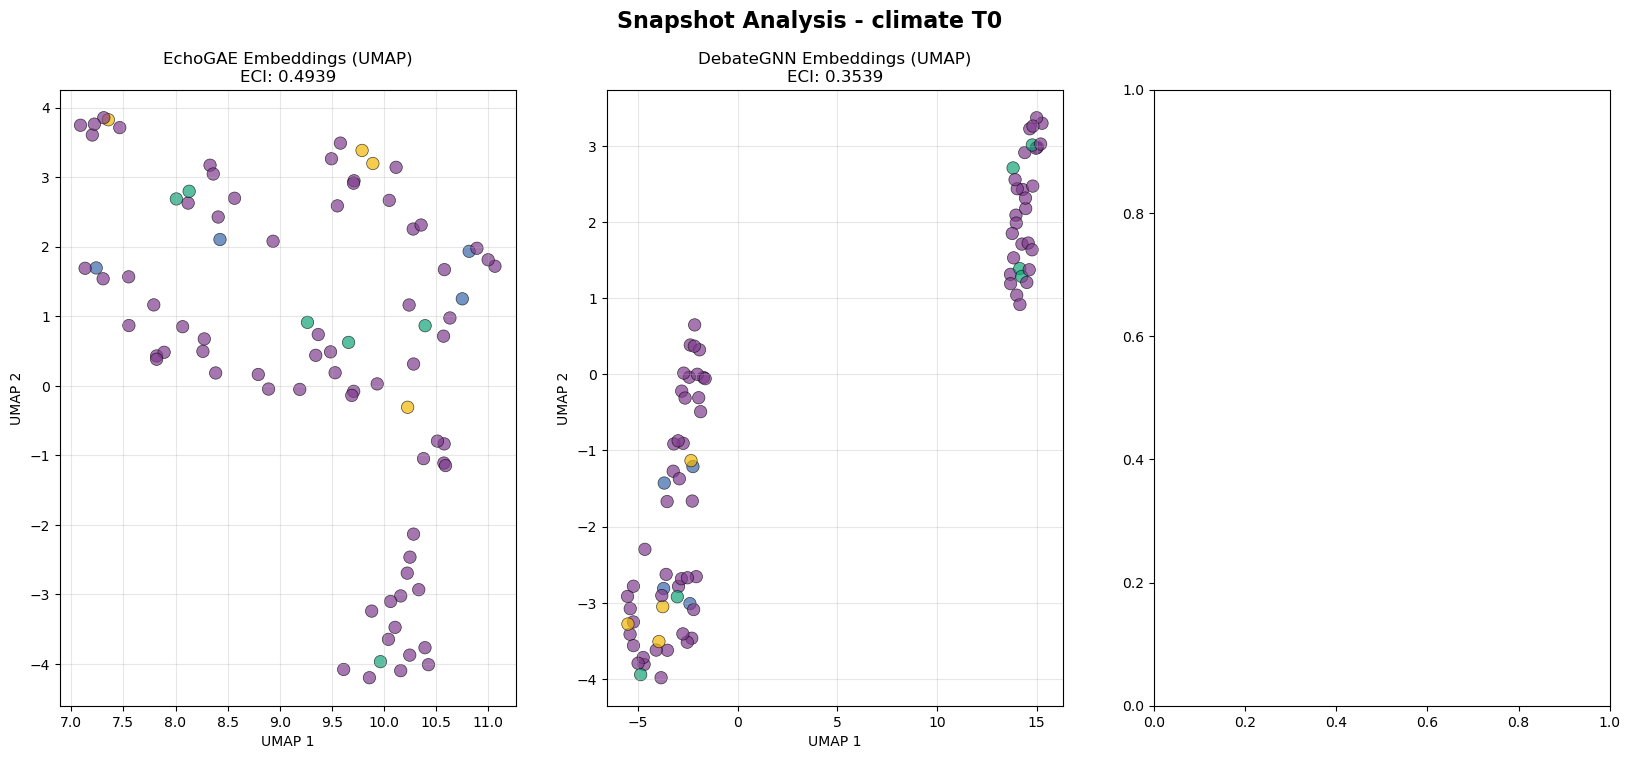

In [20]:
def plot_snapshot_analysis(processed_dict_single_subreddit, timestep, evolution_data=None, 
                          subreddit_name=None, figsize=(20, 8), 
                          color_mode="lineage", draw_boundaries=True):
    """
    Create 3 subplots: EchoGAE UMAP, DebateGNN UMAP, and NetworkX graph visualization
    
    Args:
        processed_dict_single_subreddit: dict {timestep: data} for a single subreddit
        timestep: int, timestep to analyze
        evolution_data: optional evolution data for lineage colors
        subreddit_name: optional name for the subreddit
        figsize: tuple for figure size
        color_mode: str, "lineage" (uses evolution_data) or "unique" (unique per community) or "default" (simple cycling)
        draw_boundaries: bool, whether to draw community boundary lines on NetworkX graph
    """
    if timestep not in processed_dict_single_subreddit:
        print(f"Timestep {timestep} not found in data")
        return
    
    data = processed_dict_single_subreddit[timestep]
    community_info = data['community_info']
    
    # Extract data
    echogae_embeddings = data['echogae_embeddings']
    gnn_embeddings = data['gnn_embeddings']
    nx_graph = data['nx_graph']
    comm_labels = community_info['comm_labels']
    comm_nodes = community_info['comm_nodes']
    partition = community_info['partition']  # user_id -> comm_id mapping
    
    # Check overlap between nx nodes and partition keys
    nx_nodes_set = set(nx_graph.nodes())
    partition_keys_set = set(partition.keys())
    overlap = nx_nodes_set.intersection(partition_keys_set)
    print(f"  Overlap between nx_nodes and partition keys: {len(overlap)}/{len(nx_nodes_set)}")
    
    # CREATE COLOR MAP based on color_mode
    unique_communities = sorted(comm_nodes.keys())
    
    if color_mode == "lineage" and evolution_data is not None:
        print("  Using lineage colors consistent with Sankey diagrams")
        node_color_map = build_lineage_colors(
            processed_dict_single_subreddit,
            evolution_data,
            mode="hungarian",
            min_jaccard_parent=0.05,
            split_strategy="new_hues"
        )
        # Create community color mapping using lineage colors
        comm_color_map = {}
        for comm_id in unique_communities:
            node_key = f"{timestep}_{comm_id}"
            hex_color = node_color_map.get(node_key, "#999999")
            comm_color_map[comm_id] = hex_color
        color_info = "Lineage Colors"
        
    elif color_mode == "unique":
        print("  Using unique colors per community")
        node_color_map = build_unique_node_colors(processed_dict_single_subreddit)
        # Create community color mapping using unique colors
        comm_color_map = {}
        for comm_id in unique_communities:
            node_key = f"{timestep}_{comm_id}"
            hex_color = node_color_map.get(node_key, "#999999")
            comm_color_map[comm_id] = hex_color
        color_info = "Unique Colors"
        
    else:  # color_mode == "default" or fallback
        print("  Using default color cycling")
        # Simple color cycling using matplotlib default colors
        default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        comm_color_map = {}
        for i, comm_id in enumerate(unique_communities):
            comm_color_map[comm_id] = default_colors[i % len(default_colors)]
        color_info = "Default Colors"
    
    print(f"  Community color map: {comm_color_map}")
    
    # Create node colors array based on community labels (same order as embeddings)
    node_colors = [comm_color_map[comm_labels[i]] for i in range(len(comm_labels))]
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    title_suffix = f" - {subreddit_name} T{timestep}" if subreddit_name else f" - T{timestep}"
    fig.suptitle(f'Snapshot Analysis{title_suffix}', fontsize=16, fontweight='bold')
    
    # Plot 1: EchoGAE UMAP with Connectivity
    if echogae_embeddings is not None and echogae_embeddings.shape[0] > 0:
        import umap
        import plotly.graph_objects as go
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        # Fit UMAP reducer
        reducer_echo = umap.UMAP(
            n_components=2, 
            random_state=42, 
            n_neighbors=min(15, echogae_embeddings.shape[0]-1)
        )
        echo_embedding = reducer_echo.fit_transform(echogae_embeddings)
        
        # Keep the UMAP connectivity plot
        try:
            import umap.plot
            
            # Create connectivity plot using UMAP's built-in functionality
            fig_connectivity = umap.plot.connectivity(
                reducer_echo, 
                show_points=True,
                edge_bundling='hammer'  # Options: 'hammer', 'datashader', None
            )
            
            # Display the connectivity plot
            fig_connectivity.show()
            
        except ImportError as e:
            print(f"  umap.plot not available: {e}")
            print("  Install with: pip install umap-learn[plot]")
        except Exception as e:
            print(f"  UMAP connectivity plot failed: {e}")
        
        # Create interactive UMAP scatter plot with Plotly
        # Prepare hover data
        hover_data = []
        node_names = list(partition.keys()) if partition else list(nx_graph.nodes()) if nx_graph.number_of_nodes() > 0 else [f"Node_{i}" for i in range(len(comm_labels))]

        for i in range(len(comm_labels)):
            comm_id = comm_labels[i]
            comm_size = len(comm_nodes[comm_id])
            echo_eci = data['echogae_comm_eci'][list(unique_communities).index(comm_id)]
            
            node_name = node_names[i] if i < len(node_names) else f"Node_{i}"
            hover_data.append({
                'Node_Name': str(node_name),
                'Node_Index': i,  # ADD THIS MISSING FIELD
                'Community_ID': comm_id,
                'Community_Size': comm_size,
                'Community_ECI': f"{echo_eci:.4f}",
                'X_Coord': f"{echo_embedding[i, 0]:.3f}",
                'Y_Coord': f"{echo_embedding[i, 1]:.3f}"
            })
        
        # Create interactive Plotly scatter plot
        fig_echo_interactive = go.Figure()
        
        # Add scatter points grouped by community for better legend
        for comm_id in unique_communities:
            comm_mask = comm_labels == comm_id
            comm_indices = np.where(comm_mask)[0]
            
            fig_echo_interactive.add_trace(go.Scatter(
                x=echo_embedding[comm_mask, 0],
                y=echo_embedding[comm_mask, 1],
                mode='markers',
                marker=dict(
                    color=comm_color_map[comm_id],
                    size=8,
                    line=dict(color='black', width=0.5)
                ),
                name=f'Community {comm_id} ({len(comm_indices)})',
                hovertemplate='<b>%{customdata[0]}</b><br>' +
                             'Node Index: %{customdata[1]}<br>' +
                             'Community: %{customdata[2]}<br>' +
                             'Comm Size: %{customdata[3]}<br>' +
                             'Comm ECI: %{customdata[4]}<br>' +
                             'UMAP X: %{customdata[5]}<br>' +
                             'UMAP Y: %{customdata[6]}<br>' +
                             '<extra></extra>',
                customdata=[[hover_data[i]['Node_Name'], 
                           hover_data[i]['Node_Index'],
                           hover_data[i]['Community_ID'],
                           hover_data[i]['Community_Size'],
                           hover_data[i]['Community_ECI'],
                           hover_data[i]['X_Coord'],
                           hover_data[i]['Y_Coord']] for i in comm_indices]
            ))
        
        fig_echo_interactive.update_layout(
            title=f'EchoGAE Embeddings (UMAP) - Interactive<br>ECI: {data["echogae_eci"]:.4f}',
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            width=600,
            height=500,
            showlegend=True,
            legend=dict(
                orientation="v",
                yanchor="top",
                y=1,
                xanchor="left",
                x=1.01
            )
        )
        
        fig_echo_interactive.show()
        
        # Still create the regular matplotlib scatter plot for the subplot
        scatter1 = ax1.scatter(echo_embedding[:, 0], echo_embedding[:, 1], 
                             c=node_colors, s=80, alpha=0.7, 
                             edgecolors='black', linewidth=0.5)
        ax1.set_title(f'EchoGAE Embeddings (UMAP)\nECI: {data["echogae_eci"]:.4f}')
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No EchoGAE embeddings', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('EchoGAE Embeddings (UMAP)')

    # Plot 2: DebateGNN UMAP with Connectivity
    if gnn_embeddings is not None and gnn_embeddings.shape[0] > 0:
        try:
            import umap.plot
            
            reducer_gnn = umap.UMAP(
                n_components=2, 
                random_state=42,
                n_neighbors=min(15, gnn_embeddings.shape[0]-1)
            )
            gnn_embedding = reducer_gnn.fit_transform(gnn_embeddings)
            
            # Keep the connectivity plot
            fig_connectivity_gnn = umap.plot.connectivity(
                reducer_gnn, 
                show_points=True,
                edge_bundling='hammer'
            )
            fig_connectivity_gnn.show()
            
        except ImportError as e:
            print(f"  umap.plot not available: {e}")
        except Exception as e:
            print(f"  UMAP connectivity plot failed: {e}")
        
        # Create interactive UMAP scatter plot for DebateGNN
        hover_data_gnn = []
        for i in range(len(comm_labels)):
            comm_id = comm_labels[i]
            comm_size = len(comm_nodes[comm_id])
            debgnn_eci = data['debgnn_comm_eci'][list(unique_communities).index(comm_id)]
            # Get actual node name if available
            node_name = node_names[i] if i < len(node_names) else f"Node_{i}"
            
            hover_data_gnn.append({
                'Node_Name': str(node_name),
                'Node_Index': i,
                'Community_ID': comm_id,
                'Community_Size': comm_size,
                'Community_ECI': f"{debgnn_eci:.4f}",
                'X_Coord': f"{gnn_embedding[i, 0]:.3f}",
                'Y_Coord': f"{gnn_embedding[i, 1]:.3f}"
            })
        
        # Create interactive Plotly scatter plot for DebateGNN
        fig_gnn_interactive = go.Figure()
        
        for comm_id in unique_communities:
            comm_mask = comm_labels == comm_id
            comm_indices = np.where(comm_mask)[0]
            
            fig_gnn_interactive.add_trace(go.Scatter(
                x=gnn_embedding[comm_mask, 0],
                y=gnn_embedding[comm_mask, 1],
                mode='markers',
                marker=dict(
                    color=comm_color_map[comm_id],
                    size=8,
                    line=dict(color='black', width=0.5)
                ),
                name=f'Community {comm_id} ({len(comm_indices)})',
                hovertemplate='<b>%{customdata[0]}</b><br>' +
                             'Node Index: %{customdata[1]}<br>' +
                             'Community: %{customdata[2]}<br>' +
                             'Comm Size: %{customdata[3]}<br>' +
                             'Comm ECI: %{customdata[4]}<br>' +
                             'UMAP X: %{customdata[5]}<br>' +
                             'UMAP Y: %{customdata[6]}<br>' +
                             '<extra></extra>',
                customdata=[[hover_data_gnn[i]['Node_Name'], 
                           hover_data_gnn[i]['Node_Index'],
                           hover_data_gnn[i]['Community_ID'],
                           hover_data_gnn[i]['Community_Size'],
                           hover_data_gnn[i]['Community_ECI'],
                           hover_data_gnn[i]['X_Coord'],
                           hover_data_gnn[i]['Y_Coord']] for i in comm_indices]
            ))
        
        fig_gnn_interactive.update_layout(
            title=f'DebateGNN Embeddings (UMAP) - Interactive<br>ECI: {data["debgnn_eci"]:.4f}',
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            width=600,
            height=500,
            showlegend=True,
            legend=dict(
                orientation="v",
                yanchor="top",
                y=1,
                xanchor="left",
                x=1.01
            )
        )
        
        fig_gnn_interactive.show()
        
        # Regular matplotlib scatter plot
        scatter2 = ax2.scatter(gnn_embedding[:, 0], gnn_embedding[:, 1], 
                             c=node_colors, s=80, alpha=0.7, 
                             edgecolors='black', linewidth=0.5)
        ax2.set_title(f'DebateGNN Embeddings (UMAP)\nECI: {data["debgnn_eci"]:.4f}')
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No DebateGNN embeddings', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('DebateGNN Embeddings (UMAP)')
    
    # Plot 3: NetworkX Graph
    if nx_graph.number_of_nodes() > 0:
        # Create node color mapping for NetworkX (map user_ids to colors)
        nx_node_colors = []
        nodes_with_colors = 0
        nodes_without_colors = 0
        
        for node in nx_graph.nodes():
            if node in partition:
                comm_id = partition[node]
                color = comm_color_map.get(comm_id, 'gray')
                nx_node_colors.append(color)
                nodes_with_colors += 1
            else:
                nx_node_colors.append('gray')
                nodes_without_colors += 1
        
        print(f"  NetworkX coloring: {nodes_with_colors} nodes with colors, {nodes_without_colors} nodes without colors")
        print(f"  Sample nx_node_colors: {nx_node_colors[:10]}")
        
        # Use community-aware layout for positioning
        if nx_graph.number_of_nodes() <= 500:  # Only for smaller graphs
            try:
                # Try community-aware layout first
                from networkx.algorithms import community as nx_comm
                
                # Convert partition to format expected by NetworkX community functions
                # partition is {user_id: community_id}, we need list of sets
                communities = {}
                for node, comm_id in partition.items():
                    if node in nx_graph.nodes():  # Only include nodes that exist in graph
                        if comm_id not in communities:
                            communities[comm_id] = set()
                        communities[comm_id].add(node)
                
                # Convert to list of sets (expected format for some layout functions)
                community_list = [communities[comm_id] for comm_id in sorted(communities.keys())]
                
                print(f"  Community layout: {len(community_list)} communities for positioning")
                
                # Method 1: Use spring layout with community-based initial positions
                # Create initial positions where communities are separated
                pos = {}
                import math
                n_communities = len(community_list)
                
                if n_communities > 1:
                    # Arrange communities in a circle
                    for i, community in enumerate(community_list):
                        angle = 2 * math.pi * i / n_communities
                        center_x = 3 * math.cos(angle)  # Communities spread in circle
                        center_y = 3 * math.sin(angle)
                        
                        # Position nodes within each community using spring layout
                        if len(community) > 1:
                            subgraph = nx_graph.subgraph(community)
                            sub_pos = nx.spring_layout(subgraph, k=0.3, iterations=30)
                            # Offset the subgraph positions to the community center
                            for node, (x, y) in sub_pos.items():
                                pos[node] = (center_x + x, center_y + y)
                        else:
                            # Single node community
                            node = list(community)[0]
                            pos[node] = (center_x, center_y)
                else:
                    # Fallback to regular spring layout if only one community
                    pos = nx.spring_layout(nx_graph, k=1/np.sqrt(nx_graph.number_of_nodes()), iterations=50, seed=42)
                
                # Refine positions with spring layout using initial positions
                pos = nx.spring_layout(nx_graph, pos=pos, k=1.0, iterations=50, seed=42)
                
            except Exception as e:
                print(f"  Community layout failed ({e}), using regular spring layout")
                # Fallback to regular spring layout
                pos = nx.spring_layout(nx_graph, k=1/np.sqrt(nx_graph.number_of_nodes()), iterations=50, seed=42)
            
            # Draw the graph
            nx.draw_networkx_nodes(nx_graph, pos, node_color=nx_node_colors, node_size=80,
                                alpha=0.8, ax=ax3, edgecolors='black', linewidths=0.5)
            nx.draw_networkx_edges(nx_graph, pos, alpha=0.4, width=0.8, ax=ax3, arrows=True, 
                                arrowsize=8, edge_color='#303030', 
                                min_source_margin=0, min_target_margin=0, connectionstyle="arc3,rad=0.05")
                    
            # Optional: Add community boundary circles (controlled by draw_boundaries parameter)
            if draw_boundaries and len(community_list) > 1 and nx_graph.number_of_nodes() <= 200:
                print(f"  Drawing community boundaries for {len(community_list)} communities")
                for i, community in enumerate(community_list):
                    if len(community) > 3:  # Only draw boundary for communities with enough nodes
                        community_nodes = list(community)
                        x_coords = [pos[node][0] for node in community_nodes]
                        y_coords = [pos[node][1] for node in community_nodes]
                        
                        # Create convex hull around community
                        try:
                            from scipy.spatial import ConvexHull
                            points = list(zip(x_coords, y_coords))
                            if len(points) >= 3:
                                hull = ConvexHull(points)
                                # Get community color for boundary
                                comm_id = sorted(communities.keys())[i]
                                boundary_color = comm_color_map.get(comm_id, 'gray')
                                # Draw hull boundary
                                for simplex in hull.simplices:
                                    ax3.plot([points[simplex[0]][0], points[simplex[1]][0]], 
                                            [points[simplex[0]][1], points[simplex[1]][1]], 
                                            '--', alpha=0.3, color=boundary_color)
                        except Exception as boundary_error:
                            print(f"    Boundary drawing failed for community {i}: {boundary_error}")
            elif not draw_boundaries:
                print("  Skipping boundary drawing (draw_boundaries=False)")
        
        else:
            ax3.text(0.5, 0.5, f'Graph too large\n({nx_graph.number_of_nodes()} nodes)\nfor visualization', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        
        boundary_info = " (with boundaries)" if draw_boundaries else " (no boundaries)"
        ax3.set_title(f'Network Graph (Community Layout){boundary_info}\n{nx_graph.number_of_nodes()} nodes, {nx_graph.number_of_edges()} edges')
        ax3.axis('off')
    else:
        ax3.text(0.5, 0.5, 'Empty graph', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Network Graph')
        ax3.axis('off')
    
    # Create legend for communities using chosen colors
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=f'Community {comm_id} ({len(comm_nodes[comm_id])})') 
                      for comm_id, color in comm_color_map.items()]
    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.02), 
              ncol=min(len(unique_communities), 6), title=color_info)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for legend
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"SNAPSHOT SUMMARY{title_suffix}")
    print(f"{'='*60}")
    print(f"Communities: {len(unique_communities)}")
    print(f"Nodes: {nx_graph.number_of_nodes()}")
    print(f"Edges: {nx_graph.number_of_edges()}")
    print(f"Modularity: {community_info['modularity']:.3f}")
    print(f"EchoGAE ECI: {data['echogae_eci']:.4f}")
    print(f"DebateGNN ECI: {data['debgnn_eci']:.4f}")
    print(f"Color scheme: {color_info}")
    print(f"Boundaries drawn: {draw_boundaries}")
    
    for comm_id, nodes in comm_nodes.items():
        echo_comm_eci = data['echogae_comm_eci'][list(unique_communities).index(comm_id)]
        debgnn_comm_eci = data['debgnn_comm_eci'][list(unique_communities).index(comm_id)]
        print(f"  Community {comm_id}: {len(nodes)} nodes, EchoGAE ECI: {echo_comm_eci:.4f}, DebateGNN ECI: {debgnn_comm_eci:.4f}")




# Updated usage example with options:
# Updated usage example with options:
if __name__ == "__main__":
    if 2 in processed_dict:
        subreddit_name = processed_dict[2][list(processed_dict[2].keys())[0]]['community_info']['subreddit']
        
        # COMPUTE EVOLUTION DATA FOR SUBREDDIT 2
        analyzer = CommunityEvolutionAnalyzer(verbose=True, matrix_display_limit=10)
        evolution_data_sub2 = analyzer.analyze_evolution(processed_dict[2])

        # Plot each timestep with different options
        for timestep in sorted(processed_dict[2].keys()):
            # Example 1: Lineage colors with boundaries
            plot_snapshot_analysis(
                processed_dict_single_subreddit=processed_dict[2], 
                timestep=timestep, 
                evolution_data=evolution_data_sub2,  # USE evolution data for subreddit 2
                subreddit_name=subreddit_name,
                color_mode="lineage",  # "lineage", "unique", or "default"
                draw_boundaries=False   # True or False
            )

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import normalize
# from sklearn.neighbors import NearestNeighbors

# def find_divergent_pairs(processed_dict, subreddit_id, timestep,
#                          k_neighbors=20,
#                          echo_close_thresh=0.80,   # cosine similarity in EchoGAE
#                          gnn_far_thresh=0.30,      # cosine similarity in DebateGNN
#                          gnn_close_thresh=0.80,    # inverse query
#                          echo_far_thresh=0.30,     # inverse query
#                          top_k=50,
#                          index_to_user=None):
#     """
#     Find user pairs that EchoGAE groups (high sim) but DebateGNN separates (low sim),
#     and the inverse (DebateGNN groups but EchoGAE separates).

#     index_to_user: optional list/array mapping embedding row index -> user_id.
#                    If None, will try to use indices only.
#     """
#     data = processed_dict[subreddit_id][timestep]
#     X_echo = data['echogae_embeddings']
#     X_gnn  = data['gnn_embeddings']
#     labels = data['community_info']['comm_labels']

#     if X_echo is None or X_gnn is None:
#         raise ValueError("Missing embeddings for this subreddit/timestep.")

#     # Normalize for cosine similarity (dot product)
#     X1 = normalize(X_echo.astype(np.float32))
#     X2 = normalize(X_gnn.astype(np.float32))

#     n = X1.shape[0]
#     # Nearest neighbors in EchoGAE space
#     nn_echo = NearestNeighbors(n_neighbors=min(k_neighbors+1, n), metric='cosine').fit(X1)
#     dists1, idxs1 = nn_echo.kneighbors(X1, return_distance=True)
#     sims1 = 1.0 - dists1  # cosine similarity

#     # Helper to build rows
#     def row(i, j, s_echo, s_gnn):
#         uid_i = index_to_user[i] if (index_to_user is not None and i < len(index_to_user)) else i
#         uid_j = index_to_user[j] if (index_to_user is not None and j < len(index_to_user)) else j
#         return {
#             'i_idx': i, 'j_idx': j,
#             'i_user': uid_i, 'j_user': uid_j,
#             'i_comm': int(labels[i]), 'j_comm': int(labels[j]),
#             'same_leiden': bool(labels[i] == labels[j]),
#             'sim_echogae': float(s_echo),
#             'sim_debgnn': float(s_gnn),
#             'delta_echo_minus_gnn': float(s_echo - s_gnn)
#         }

#     # EchoGAE-close, DebateGNN-far
#     seen = set()
#     rows_echo_close = []
#     for i in range(n):
#         for t in range(1, idxs1.shape[1]):  # skip self at t=0
#             j = int(idxs1[i, t])
#             if i >= j:  # unique unordered pairs
#                 continue
#             s_echo = float(sims1[i, t])
#             if s_echo < echo_close_thresh:
#                 continue
#             s_gnn = float(np.dot(X2[i], X2[j]))
#             if s_gnn > gnn_far_thresh:
#                 continue
#             key = (i, j)
#             if key in seen:
#                 continue
#             seen.add(key)
#             rows_echo_close.append(row(i, j, s_echo, s_gnn))

#     df_echo_close = pd.DataFrame(rows_echo_close).sort_values(
#         'delta_echo_minus_gnn', ascending=False
#     ).head(top_k).reset_index(drop=True)

#     # Inverse: DebateGNN-close, EchoGAE-far
#     nn_gnn = NearestNeighbors(n_neighbors=min(k_neighbors+1, n), metric='cosine').fit(X2)
#     dists2, idxs2 = nn_gnn.kneighbors(X2, return_distance=True)
#     sims2 = 1.0 - dists2

#     seen = set()
#     rows_gnn_close = []
#     for i in range(n):
#         for t in range(1, idxs2.shape[1]):
#             j = int(idxs2[i, t])
#             if i >= j:
#                 continue
#             s_gnn = float(sims2[i, t])
#             if s_gnn < gnn_close_thresh:
#                 continue
#             s_echo = float(np.dot(X1[i], X1[j]))
#             if s_echo > echo_far_thresh:
#                 continue
#             key = (i, j)
#             if key in seen:
#                 continue
#             seen.add(key)
#             rows_gnn_close.append(row(i, j, s_echo, s_gnn))

#     df_gnn_close = pd.DataFrame(rows_gnn_close).sort_values(
#         'delta_echo_minus_gnn'
#     ).head(top_k).reset_index(drop=True)

#     return df_echo_close, df_gnn_close

# def try_build_index_to_user(processed_dict_single_subreddit, timestep):
#     """
#     Extract node index -> user_id mapping from processed data.
#     """
#     data = processed_dict_single_subreddit[timestep]
    
#     # Check if we stored the PyG node mapping during processing
#     if 'index_to_user' in data and data['index_to_user'] is not None:
#         mapping = data['index_to_user']
#         print(f"Found PyG node mapping: {type(mapping)}, length: {len(mapping)}")
#         print(f"Sample mapping: {mapping[:5]}")
#         return mapping
    
#     # Fallback: try to extract from nx_graph nodes (but warn about ordering)
#     if 'nx_graph' in data and data['nx_graph'] is not None:
#         nx_graph = data['nx_graph']
#         node_list = list(nx_graph.nodes())
#         print(f"WARNING: Using NetworkX nodes as fallback (order may not match embeddings!)")
#         print(f"NetworkX nodes: {len(node_list)}, sample: {node_list[:5]}")
#         return node_list
    
#     print("No index->user mapping found. Returning None (will show indices).")
#     return None

# # Re-run the divergent pairs analysis with proper user IDs
# sub = next(iter(processed_dict.keys()))
# ts = sorted(processed_dict[sub].keys())[0]

# # This should now find the PyG node mapping
# idx_to_user = try_build_index_to_user(processed_dict[sub], ts)

# df_echo_close, df_gnn_close = find_divergent_pairs(
#     processed_dict, subreddit_id=sub, timestep=ts,
#     k_neighbors=20,
#     echo_close_thresh=0.85, gnn_far_thresh=0.25,
#     gnn_close_thresh=0.85, echo_far_thresh=0.25,
#     top_k=40,
#     index_to_user=idx_to_user
# )

# print("Pairs EchoGAE groups (high sim) but DebateGNN separates (low sim):")
# display(df_echo_close.head(20))

# print("\nPairs DebateGNN groups (high sim) but EchoGAE separates (low sim):")
# display(df_gnn_close.head(20))

Found PyG node mapping: <class 'list'>, length: 29
Sample mapping: ['APB2710', 'AnomalyNexus', 'ArchbishopMegatronQC', 'Bozata1', 'EthiczGradient']
Pairs EchoGAE groups (high sim) but DebateGNN separates (low sim):


i_idx  j_idx           i_user           j_user  i_comm  j_comm  \
0       9     22           Prituh         hishnash       1       1   
1       9     10           Prituh        ScarletIT       1       1   
2       5     16  Greengoblingogo  Tinkers_toenail       2       0   
3       9     28           Prituh          yacc143       1       0   
4       6      9        Heruss100           Prituh       0       1   
5       4      9   EthiczGradient           Prituh       2       1   
6       9     18           Prituh      amgiecorker       1       1   
7       8      9   Petemcfuzzbuzz           Prituh       0       1   
8       5     21  Greengoblingogo        firdseven       2       0   
9       3     12          Bozata1           Skraff       2       1   
10     12     27           Skraff        uberdavis       1       0   
11      9     13           Prituh   SniggeringFool       1       0   
12      5     19  Greengoblingogo           aslate       2       1   
13      7      9    MrPuddington2           Prituh       0       1   
14      9     14           Prituh    StrixTechnica       1       1   
15      0     26          APB2710       tweeglitch       2       0   
16      9     15           Prituh    Thezenstalker       1       1   

    same_leiden  sim_echogae  sim_debgnn  delta_echo_minus_gnn  
0          True     0.976770   -0.103552              1.080322  
1          True     0.951496   -0.095711              1.047207  
2         False     0.953403   -0.090639              1.044042  
3         False     0.941346   -0.101845              1.043191  
4         False     0.964727   -0.075226              1.039954  
5         False     0.967567   -0.069389              1.036957  
6          True     0.950110   -0.084171              1.034281  
7         False     0.957086   -0.076308              1.033394  
8         False     0.905091   -0.096377              1.001469  
9         False     0.878950   -0.106579              0.985529  
10        False     0.865847   -0.106277              0.972123  
11        False     0.876523   -0.094477              0.971000  
12        False     0.866320   -0.099105              0.965424  
13        False     0.885783   -0.072884              0.958667  
14         True     0.855349   -0.087116              0.942465  
15        False     0.901981   -0.040167              0.942148  
16         True     0.859403   -0.079552              0.938954


Pairs DebateGNN groups (high sim) but EchoGAE separates (low sim):


i_idx  j_idx                i_user                j_user  i_comm  j_comm  \
0      12     26                Skraff            tweeglitch       1       0   
1       0      2               APB2710  ArchbishopMegatronQC       2       2   
2       9     11                Prituh       SideburnsOfDoom       1       1   
3       5      9       Greengoblingogo                Prituh       2       1   
4       5     26       Greengoblingogo            tweeglitch       2       0   
5       0     23               APB2710              pikadrew       2       0   
6       0     20               APB2710      blah-blah-blah12       2       0   
7       3     17               Bozata1                 Xatom       2       1   
8      11     26       SideburnsOfDoom            tweeglitch       1       0   
9       0     24               APB2710              polic293       2       0   
10      9     26                Prituh            tweeglitch       1       0   
11      0     15               APB2710         Thezenstalker       2       1   
12      0     14               APB2710         StrixTechnica       2       1   
13      0      7               APB2710         MrPuddington2       2       0   
14      0     13               APB2710        SniggeringFool       2       0   
15      0     10               APB2710             ScarletIT       2       1   
16      2      8  ArchbishopMegatronQC        Petemcfuzzbuzz       2       0   
17      0     28               APB2710               yacc143       2       0   
18     24     25              polic293              prodmerc       0       0   
19      2      6  ArchbishopMegatronQC             Heruss100       2       0   

    same_leiden  sim_echogae  sim_debgnn  delta_echo_minus_gnn  
0         False    -0.915828    0.935758             -1.851587  
1          True    -0.911893    0.906846             -1.818740  
2          True    -0.667950    0.981313             -1.649262  
3         False    -0.639448    0.979582             -1.619029  
4         False    -0.463388    0.973136             -1.436524  
5         False    -0.502281    0.916541             -1.418822  
6         False    -0.441607    0.959740             -1.401347  
7         False    -0.526240    0.855670             -1.381910  
8         False    -0.349573    0.994352             -1.343925  
9         False    -0.347692    0.963060             -1.310752  
10        False    -0.303308    0.988254             -1.291563  
11        False    -0.314267    0.964462             -1.278729  
12        False    -0.340166    0.911155             -1.251321  
13        False    -0.258031    0.970697             -1.228728  
14        False    -0.308530    0.891432             -1.199962  
15        False    -0.128323    0.896060             -1.024383  
16        False    -0.166669    0.854656             -1.021324  
17        False    -0.146425    0.861635             -1.008060  
18         True    -0.090204    0.916263             -1.006467  
19        False    -0.106492    0.881501             -0.987993

C:\Users\vduch\AppData\Local\Temp\ipykernel_33520\133049616.py:45: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s--" (-> linestyle='--'). The keyword argument will take precedence.



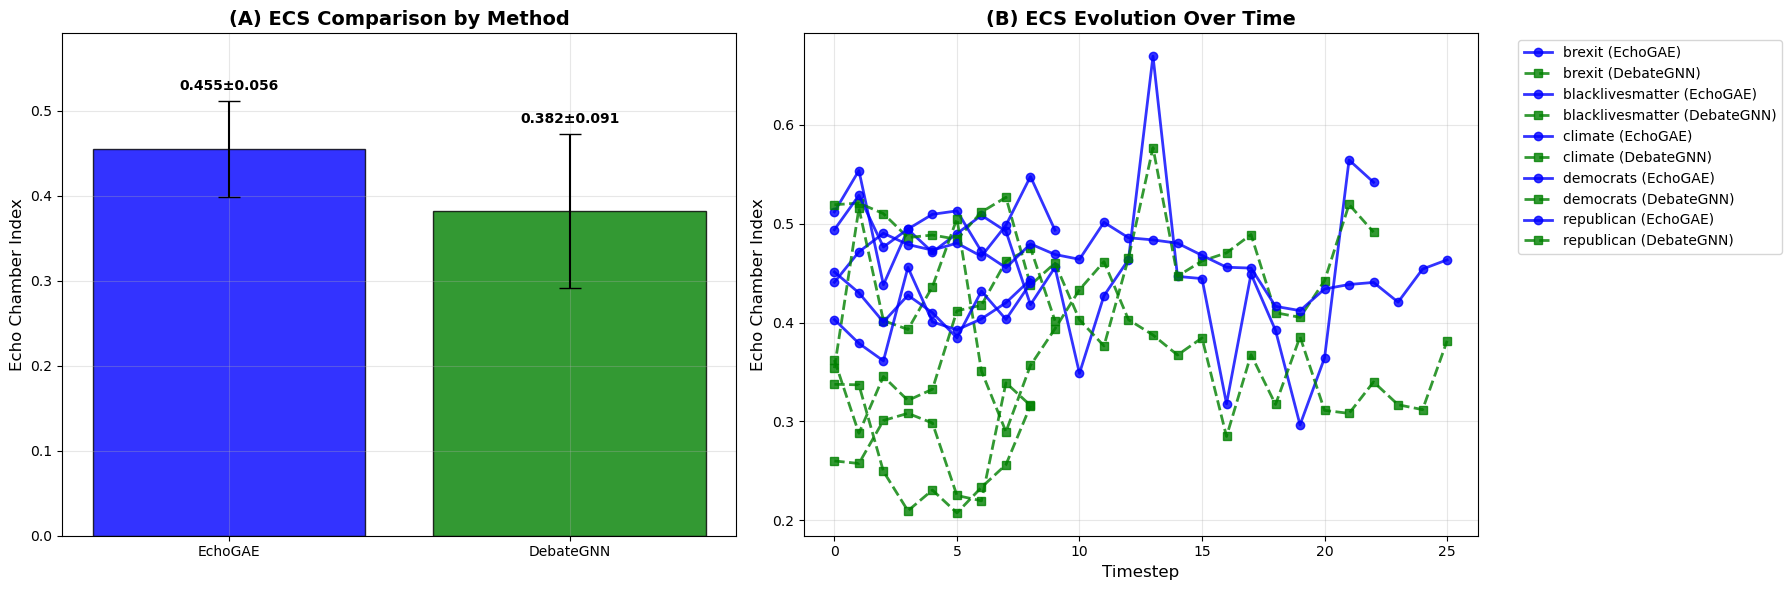

FIGURE 1 STATISTICS:
EchoGAE ECS: 0.455 ± 0.056
DebateGNN ECS: 0.382 ± 0.091
Paired t-test: t=8.379, p=0.000
Cohen's d: 0.961
Significant difference: Yes

FIGURE 2: Using r/brexit with 23 timesteps


C:\Users\vduch\AppData\Local\Temp\ipykernel_33520\4148637681.py:59: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.

C:\Users\vduch\AppData\Local\Temp\ipykernel_33520\4148637681.py:83: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.



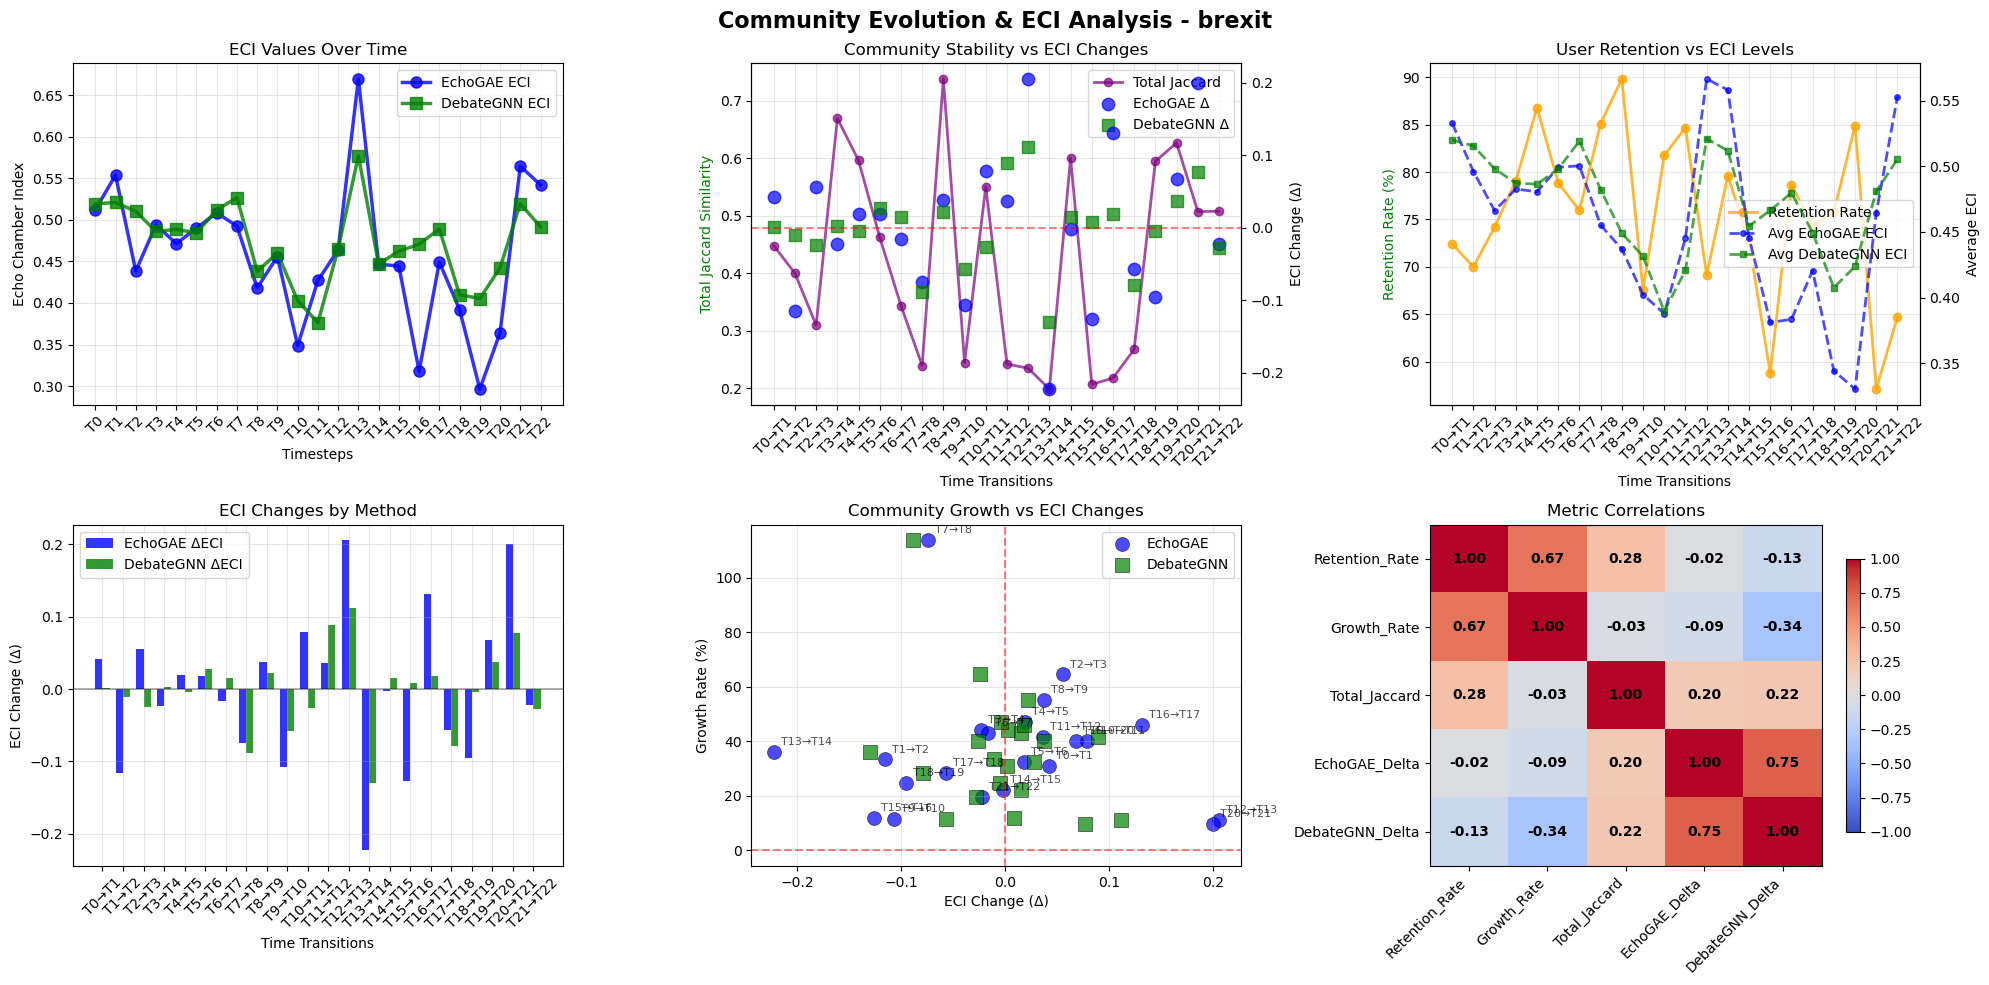


COMPREHENSIVE ANALYSIS SUMMARY - brexit

ECI EVOLUTION:
  T0: EchoGAE=0.5119, DebateGNN=0.5192
  T1: EchoGAE=0.5538, DebateGNN=0.5208
  T2: EchoGAE=0.4383, DebateGNN=0.5102
  T3: EchoGAE=0.4942, DebateGNN=0.4860
  T4: EchoGAE=0.4712, DebateGNN=0.4885
  T5: EchoGAE=0.4900, DebateGNN=0.4842
  T6: EchoGAE=0.5085, DebateGNN=0.5117
  T7: EchoGAE=0.4923, DebateGNN=0.5267
  T8: EchoGAE=0.4181, DebateGNN=0.4379
  T9: EchoGAE=0.4558, DebateGNN=0.4601
  T10: EchoGAE=0.3487, DebateGNN=0.4028
  T11: EchoGAE=0.4272, DebateGNN=0.3763
  T12: EchoGAE=0.4637, DebateGNN=0.4651
  T13: EchoGAE=0.6694, DebateGNN=0.5769
  T14: EchoGAE=0.4467, DebateGNN=0.4469
  T15: EchoGAE=0.4445, DebateGNN=0.4623
  T16: EchoGAE=0.3178, DebateGNN=0.4705
  T17: EchoGAE=0.4491, DebateGNN=0.4890
  T18: EchoGAE=0.3920, DebateGNN=0.4100
  T19: EchoGAE=0.2965, DebateGNN=0.4053
  T20: EchoGAE=0.3643, DebateGNN=0.4423
  T21: EchoGAE=0.5644, DebateGNN=0.5195
  T22: EchoGAE=0.5419, DebateGNN=0.4914

TRANSITION ANALYSIS:

Transition

c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  umap.plot not available: hammer_bundle operation requires dask and scikit-image. Ensure you install the dependency before applying bundling.
  Install with: pip install umap-learn[plot]


c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\plot.py:895: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  umap.plot not available: hammer_bundle operation requires dask and scikit-image. Ensure you install the dependency before applying bundling.


c:\Users\vduch\anaconda3\envs\mscenv\Lib\site-packages\umap\plot.py:895: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



  NetworkX coloring: 261 nodes with colors, 0 nodes without colors
  Sample nx_node_colors: ['#11A579', '#11A579', '#11A579', '#11A579', '#11A579', '#11A579', '#11A579', '#11A579', '#11A579', '#11A579']
  Community layout: 3 communities for positioning
  Skipping boundary drawing (draw_boundaries=False)


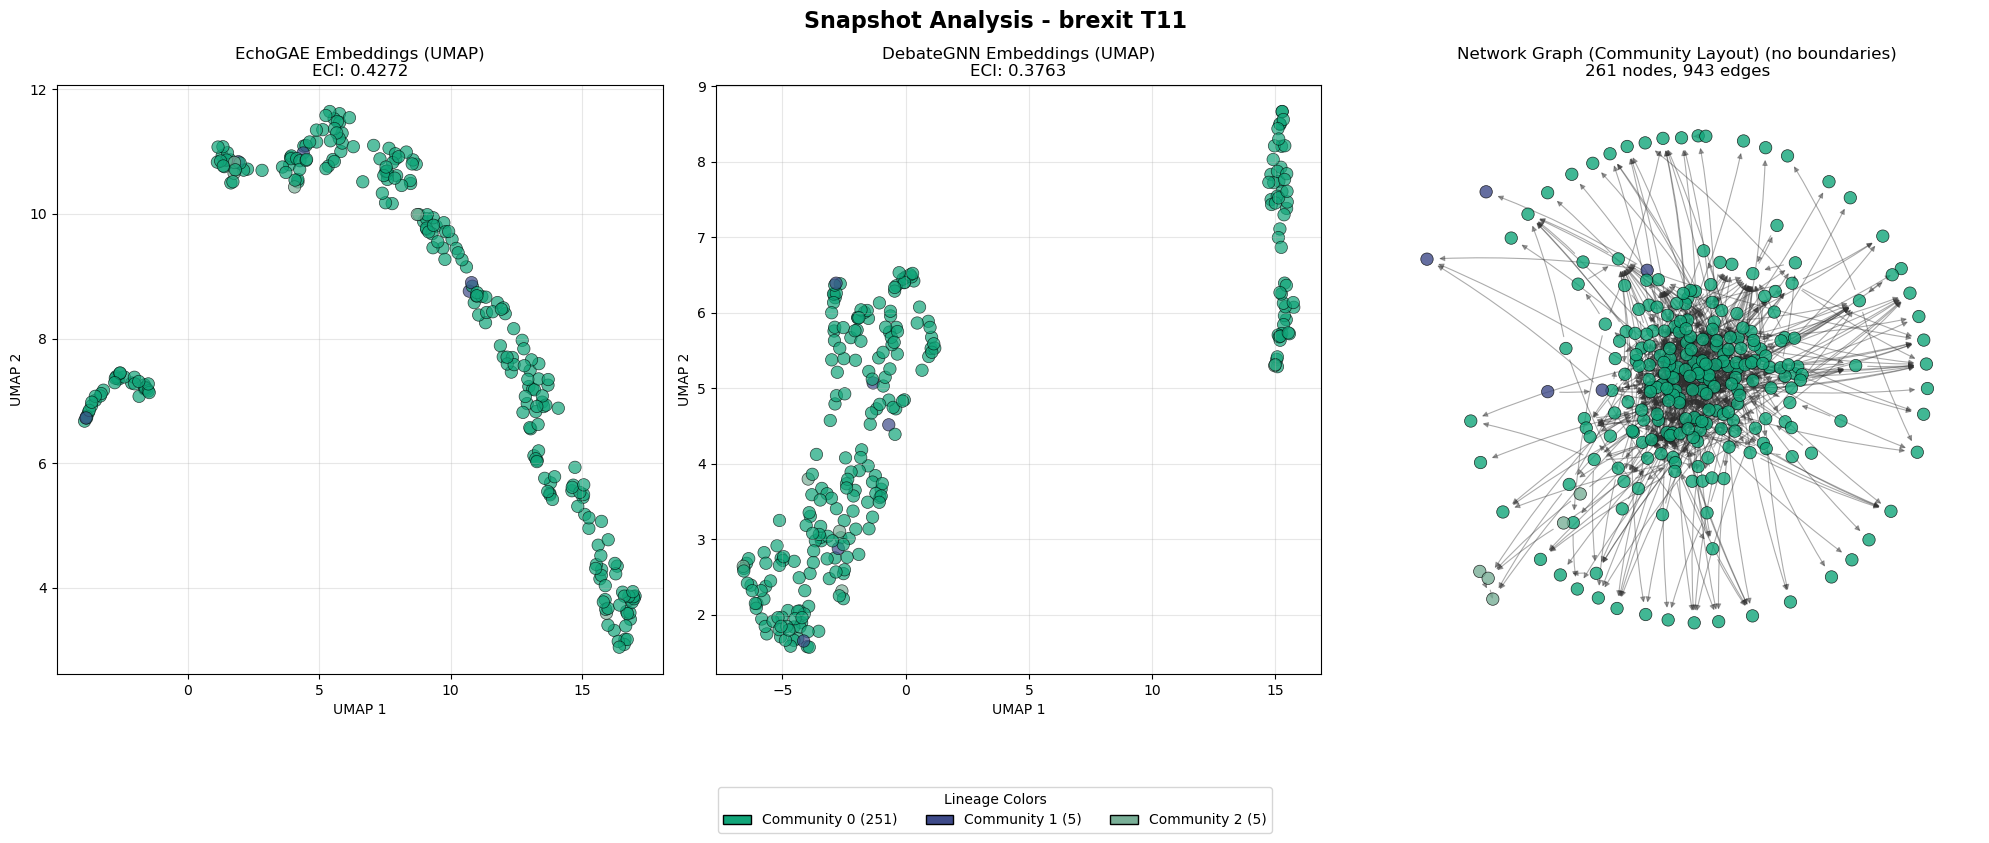


SNAPSHOT SUMMARY - brexit T11
Communities: 3
Nodes: 261
Edges: 943
Modularity: 0.017
EchoGAE ECI: 0.4272
DebateGNN ECI: 0.3763
Color scheme: Lineage Colors
Boundaries drawn: False
  Community 0: 251 nodes, EchoGAE ECI: 0.4229, DebateGNN ECI: 0.3688
  Community 1: 5 nodes, EchoGAE ECI: 0.4611, DebateGNN ECI: 0.7219
  Community 2: 5 nodes, EchoGAE ECI: 0.6066, DebateGNN ECI: 0.4101

FIGURE 4: Community flow analysis for r/brexit
Analyzing ALL user flows with thresholds:
  + Minimum flow: 3 users
  + Minimum Jaccard similarity: 0.050

Transition T0 → T1:
  Found 2 significant flows (filtered out 4):
    C1→C0: 8 users (J=0.348, Medium)
    C0→C0: 7 users (J=0.259, Low)

Transition T1 → T2:
  Found 2 significant flows (filtered out 2):
    C0→C0: 14 users (J=0.400, Medium)
    C1→C0: 6 users (J=0.194, Low)

Transition T2 → T3:
  Found 3 significant flows (filtered out 5):
    C0→C0: 6 users (J=0.167, Low)
    C0→C1: 6 users (J=0.171, Low)
    C0→C2: 6 users (J=0.176, Low)

Transition T3 →


ALL FLOWS SANKEY SUMMARY - r/brexit - Community Flow Analysis
FILTERING RESULTS:
  + Total possible flows: 271
  + Flows after filtering: 119
  + Filtered out: 152 (56.1%)
  + Filter efficiency: 43.9% flows retained

FLOW STATISTICS:
  + Total nodes (communities): 80
  + Total links (significant flows): 119
  + Total users in flows: 2,802
  + Average flow size: 23.5 users
  + Average Jaccard similarity: 0.150

FLOW STRENGTH DISTRIBUTION:
  + Strong: 5 flows (4.2%)
  + Medium: 2 flows (1.7%)
  + Low: 65 flows (54.6%)
  + Very Low: 47 flows (39.5%)

  T0 → T1: 2 flows, 15 total users, avg Jaccard: 0.304

  T1 → T2: 2 flows, 20 total users, avg Jaccard: 0.297

  T2 → T3: 3 flows, 18 total users, avg Jaccard: 0.172

  T3 → T4: 7 flows, 26 total users, avg Jaccard: 0.165

  T4 → T5: 9 flows, 42 total users, avg Jaccard: 0.146

  T5 → T6: 6 flows, 56 total users, avg Jaccard: 0.176

  T6 → T7: 2 flows, 57 total users, avg Jaccard: 0.282

  T7 → T8: 6 flows, 76 total users, avg Jaccard: 0.11

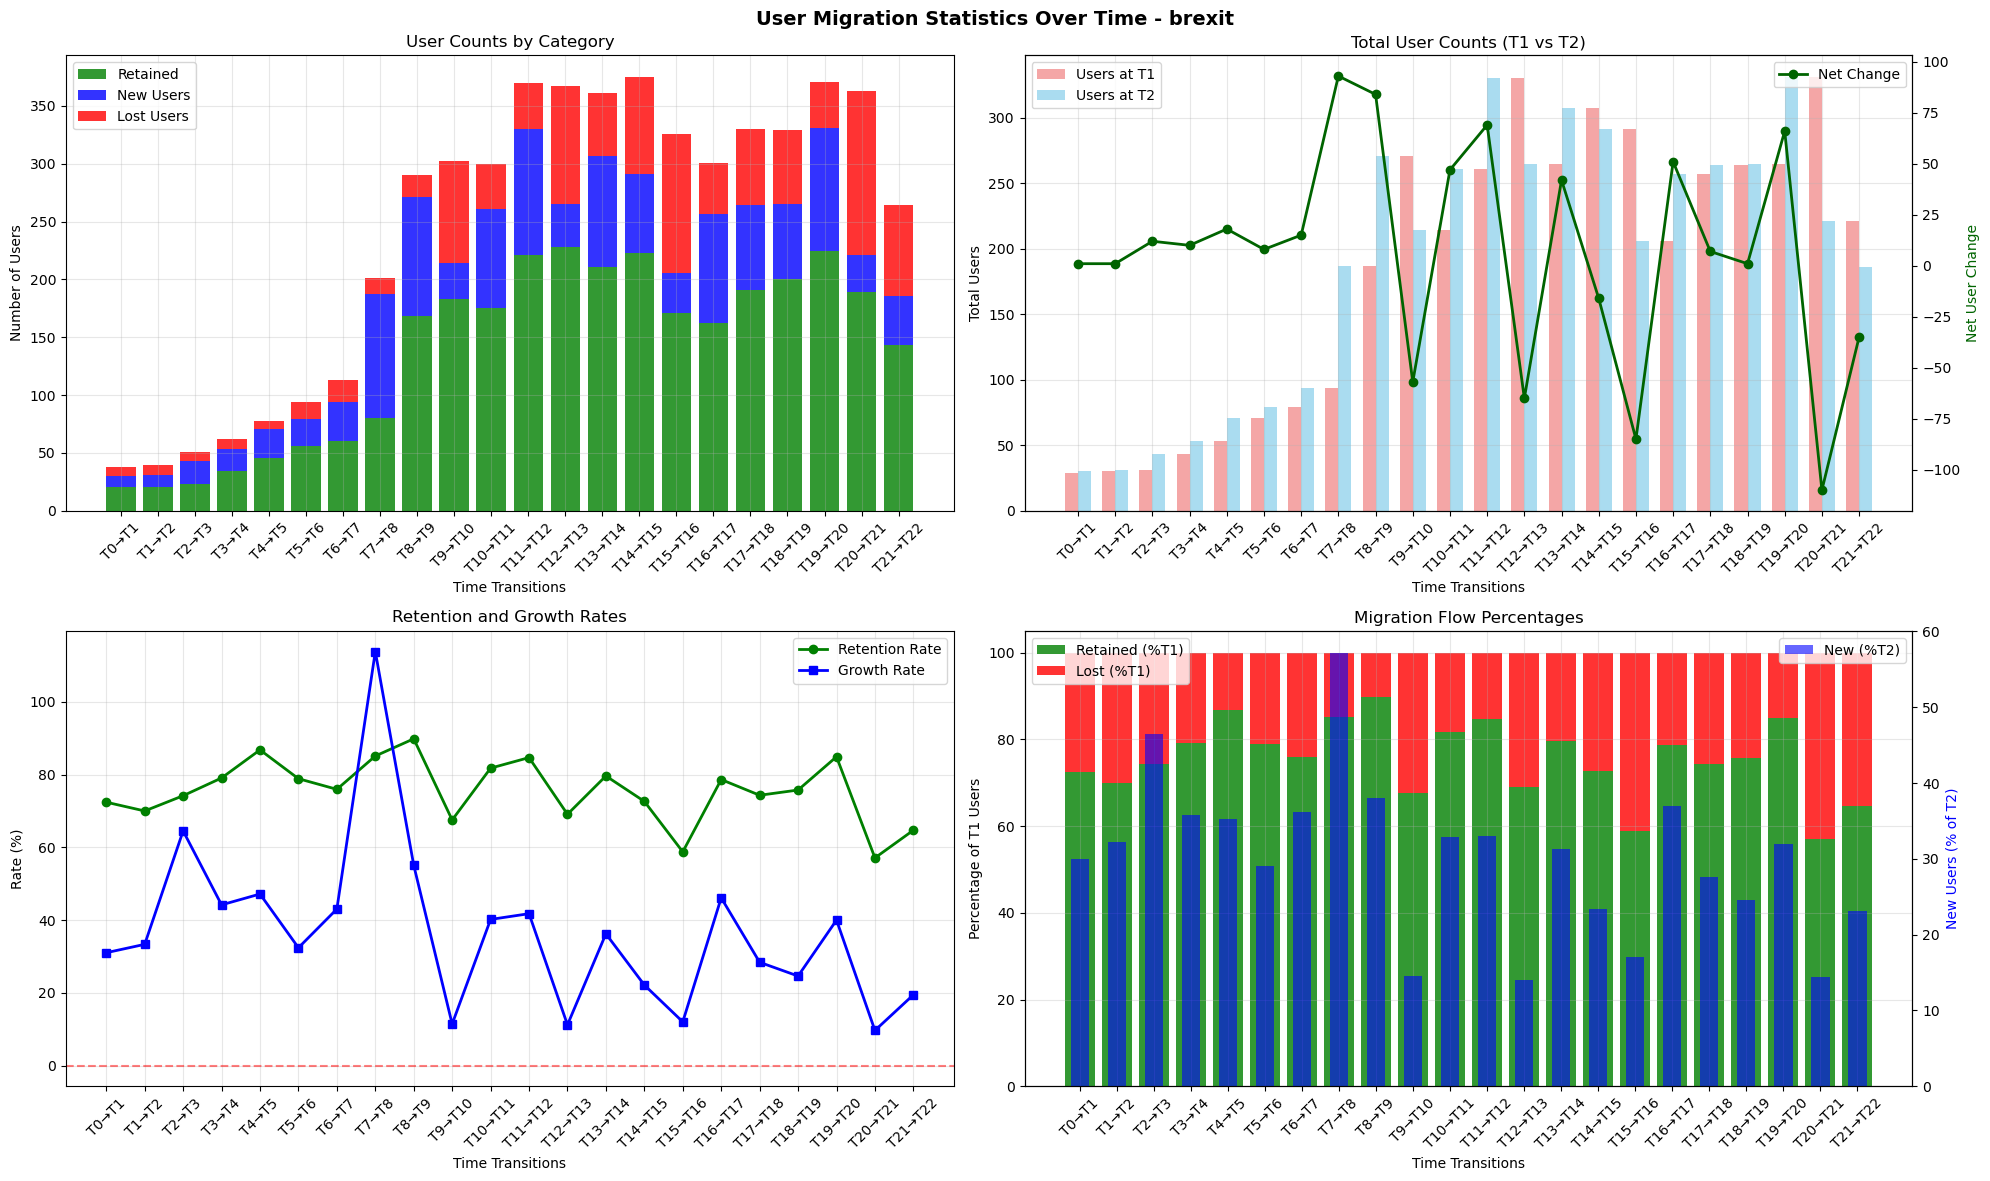


USER MIGRATION SUMMARY - brexit

Transition T0 → T1:
  Total users T0: 29
  Total users T1: 30
  Retained: 21 (72.4%)
  New: 9 (31.0%)
  Lost: 8
  Net change: +1

Transition T1 → T2:
  Total users T1: 30
  Total users T2: 31
  Retained: 21 (70.0%)
  New: 10 (33.3%)
  Lost: 9
  Net change: +1

Transition T2 → T3:
  Total users T2: 31
  Total users T3: 43
  Retained: 23 (74.2%)
  New: 20 (64.5%)
  Lost: 8
  Net change: +12

Transition T3 → T4:
  Total users T3: 43
  Total users T4: 53
  Retained: 34 (79.1%)
  New: 19 (44.2%)
  Lost: 9
  Net change: +10

Transition T4 → T5:
  Total users T4: 53
  Total users T5: 71
  Retained: 46 (86.8%)
  New: 25 (47.2%)
  Lost: 7
  Net change: +18

Transition T5 → T6:
  Total users T5: 71
  Total users T6: 79
  Retained: 56 (78.9%)
  New: 23 (32.4%)
  Lost: 15
  Net change: +8

Transition T6 → T7:
  Total users T6: 79
  Total users T7: 94
  Retained: 60 (75.9%)
  New: 34 (43.0%)
  Lost: 19
  Net change: +15

Transition T7 → T8:
  Total users T7: 94
  T

n_timesteps  echogae_eci_mean  echogae_eci_std  \
subreddit                                                          
blacklivesmatter           10             0.484            0.028   
brexit                     23             0.459            0.084   
climate                    26             0.468            0.030   
democrats                   9             0.407            0.030   
republican                  9             0.420            0.021   

                  debgnn_eci_mean  debgnn_eci_std  delta_echogae_eci_mean  \
subreddit                                                                   
blacklivesmatter            0.382           0.062                   0.006   
brexit                      0.474           0.048                   0.001   
climate                     0.375           0.060                  -0.001   
democrats                   0.280           0.042                   0.005   
republican                  0.264           0.052                  -0.001   

                  delta_echogae_eci_std  delta_debgnn_eci_mean  \
subreddit                                                        
blacklivesmatter                  0.031                  0.004   
brexit                            0.104                 -0.001   
climate                           0.023                  0.001   
democrats                         0.044                  0.007   
republican                        0.032                 -0.003   

                  delta_debgnn_eci_std  modularity_mean  \
subreddit                                                 
blacklivesmatter                 0.054            0.852   
brexit                           0.056            0.161   
climate                          0.071            0.431   
democrats                        0.056            0.180   
republican                       0.046            0.342   

                  echogae_silhouette_mean  debgnn_silhouette_mean  
subreddit                                                          
blacklivesmatter                   -0.183                  -0.356  
brexit                             -0.109                  -0.080  
climate                            -0.125                  -0.298  
democrats                          -0.211                  -0.456  
republican                         -0.200                  -0.497

DATASET OVERVIEW:
   + Subreddits analyzed: 5
   + Total timesteps: 77
   + Total communities: 927
   + Average modularity: 0.365

METHOD COMPARISON:
   + EchoGAE ECI: 0.455 ± 0.056
   + DebateGNN ECI: 0.382 ± 0.091
   + Paired t-test: t = 8.379, p < 0.001
   + Effect size (Cohen's d): 0.961
     >> Large effect size

COMMUNITY EVOLUTION (r/brexit):
   + Average Jaccard similarity: 0.418
   + Average retention rate: 75.5%
   + Average growth rate: 36.7%


In [34]:
# Add this cell after your ECS Pipeline and before Community Evolution

### **PAPER RESULTS - 4 KEY FIGURES**
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import networkx as nx
import plotly.graph_objects as go

# =============================================================================
# FIGURE 1: Method Comparison (EchoGAE vs DebateGNN)
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Figure 1A: Overall ECS comparison
methods = ['EchoGAE', 'DebateGNN']
echo_mean, echo_std = eci_df['echogae_eci'].mean(), eci_df['echogae_eci'].std()
gnn_mean, gnn_std = eci_df['debgnn_eci'].mean(), eci_df['debgnn_eci'].std()
mean_values = [echo_mean, gnn_mean]
std_values = [echo_std, gnn_std]

bars = ax1.bar(methods, mean_values, yerr=std_values, capsize=8, alpha=0.8, 
               color=['blue', 'green'], edgecolor='black', linewidth=1)
ax1.set_ylabel('Echo Chamber Index', fontsize=12)
ax1.set_title('(A) ECS Comparison by Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(mean_values) * 1.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_values, std_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

# Figure 1B: ECS evolution over time by subreddit
for sub_id in processed_dict.keys():
    timesteps = sorted(processed_dict[sub_id].keys())
    if len(timesteps) > 1:  # Only show subreddits with multiple timesteps
        subreddit_name = processed_dict[sub_id][timesteps[0]]['community_info']['subreddit']
        echogae_values = [processed_dict[sub_id][ts]['echogae_eci'] for ts in timesteps]
        debgnn_values = [processed_dict[sub_id][ts]['debgnn_eci'] for ts in timesteps]
        
        ax2.plot(timesteps, echogae_values, 'o-', alpha=0.8, linewidth=2,
                label=f'{subreddit_name} (EchoGAE)', color='blue')
        ax2.plot(timesteps, debgnn_values, 's--', alpha=0.8, linewidth=2,
                label=f'{subreddit_name} (DebateGNN)', color='green', linestyle='--')

ax2.set_xlabel('Timestep', fontsize=12)
ax2.set_ylabel('Echo Chamber Index', fontsize=12)
ax2.set_title('(B) ECS Evolution Over Time', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('results/paper_figure1_method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance test
from scipy import stats
echogae_all = eci_df['echogae_eci'].values
debgnn_all = eci_df['debgnn_eci'].values
t_stat, p_value = stats.ttest_rel(echogae_all, debgnn_all)
cohens_d = (echogae_all - debgnn_all).mean() / (echogae_all - debgnn_all).std()

print(f"FIGURE 1 STATISTICS:")
print(f"EchoGAE ECS: {echo_mean:.3f} ± {echo_std:.3f}")
print(f"DebateGNN ECS: {gnn_mean:.3f} ± {gnn_std:.3f}")
print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.3f}")
print(f"Cohen's d: {cohens_d:.3f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# =============================================================================
# FIGURE 2: Community Evolution Analysis (Single Best Subreddit)
# =============================================================================

# Select subreddit with most timesteps for detailed analysis
best_sub_id = 0
# max(processed_dict.keys(), key=lambda x: len(processed_dict[x]))
best_sub_data = processed_dict[best_sub_id]
subreddit_name = best_sub_data[list(best_sub_data.keys())[0]]['community_info']['subreddit']

# Analyze evolution
analyzer = CommunityEvolutionAnalyzer(verbose=False, matrix_display_limit=None)
evolution_data = analyzer.analyze_evolution(best_sub_data)

if evolution_data:
    print(f"\nFIGURE 2: Using r/{subreddit_name} with {len(best_sub_data)} timesteps")
    plot_combined_migration_and_eci(evolution_data, best_sub_data, subreddit_name)
    # plt.savefig('results/paper_figure2_community_evolution.png', dpi=300, bbox_inches='tight')
else:
    print("ERROR: No evolution data for Figure 2")

# =============================================================================
# FIGURE 3: Embedding Space Comparison (UMAP Visualization)
# =============================================================================

# Use middle timestep from best subreddit
timesteps = sorted(best_sub_data.keys())
mid_timestep = timesteps[len(timesteps)//2]

print(f"\nFIGURE 3: Embedding comparison for r/{subreddit_name} at T{mid_timestep}")
plot_snapshot_analysis(
    processed_dict_single_subreddit=best_sub_data, 
    timestep=mid_timestep, 
    evolution_data=evolution_data,
    subreddit_name=subreddit_name,
    color_mode="lineage",
    draw_boundaries=False
)
# plt.savefig('results/paper_figure3_embedding_comparison.png', dpi=300, bbox_inches='tight')

# =============================================================================
# FIGURE 4: Community Flow Sankey Diagram
# =============================================================================

print(f"\nFIGURE 4: Community flow analysis for r/{subreddit_name}")
if evolution_data:
    flow_details = create_all_flows_sankey(
        evolution_data=evolution_data,
        processed_dict_single_subreddit=best_sub_data,
        min_flow_threshold=3,
        min_jaccard_threshold=0.05,
        subreddit_name=f"r/{subreddit_name} - Community Flow Analysis"
    )
else:
    print("ERROR: No evolution data for Sankey diagram")

# =============================================================================
# FIGURE 5: User Migration Statistics (Detailed Community Dynamics)
# =============================================================================

print(f"\nFIGURE 5: User migration analysis for r/{subreddit_name}")
if evolution_data:
    plot_user_migration_stats(
        evolution_data=evolution_data, 
        subreddit_name=subreddit_name,
        figsize=(20, 12)  # Larger for paper quality
    )
    # plt.savefig('results/paper_figure5_user_migration.png', dpi=300, bbox_inches='tight')
    
    # Add migration insights to results summary
    migration_stats = evolution_data['migration_stats']
    total_retention = sum(s['retained'] for s in migration_stats)
    total_new = sum(s['new'] for s in migration_stats)
    total_lost = sum(s['lost'] for s in migration_stats)
    
    print(f"\nUSER MIGRATION INSIGHTS:")
    print(f"   + Total users retained across transitions: {total_retention:,}")
    print(f"   + Total new users gained: {total_new:,}")
    print(f"   + Total users lost: {total_lost:,}")
    print(f"   + Overall user turnover rate: {(total_new + total_lost)/(total_retention + total_new + total_lost)*100:.1f}%")
else:
    print("ERROR: No evolution data for user migration analysis")
    
# =============================================================================
# RESULTS SUMMARY FOR PAPER
# =============================================================================

print(f"\n{'='*80}")
print("PAPER RESULTS SUMMARY")
print(f"{'='*80}")

# Create a condensed table for the main paper
main_paper_table = eci_df.groupby('subreddit').agg({
    'timestep': 'count',
    'echogae_eci': ['mean', 'std'],
    'debgnn_eci': ['mean', 'std'],
    'delta_echogae_eci': ['mean', 'std'],
    'delta_debgnn_eci': ['mean', 'std'],
    'modularity': 'mean',
    'echogae_silhouette': 'mean',
    'debgnn_silhouette': 'mean'
}).round(3)

# Flatten column names
main_paper_table.columns = ['_'.join(col).strip() for col in main_paper_table.columns]
main_paper_table = main_paper_table.rename(columns={'timestep_count': 'n_timesteps'})

print("MAIN PAPER TABLE (Summary by Subreddit):")
display(main_paper_table)

# Save condensed version for main paper
# main_paper_table.to_csv('results/main_paper_summary.csv')

# Overall statistics
print(f"DATASET OVERVIEW:")
print(f"   + Subreddits analyzed: {len(processed_dict)}")
print(f"   + Total timesteps: {sum(len(data) for data in processed_dict.values())}")
print(f"   + Total communities: {eci_df['num_communities'].sum()}")
print(f"   + Average modularity: {eci_df['modularity'].mean():.3f}")

print(f"\nMETHOD COMPARISON:")
print(f"   + EchoGAE ECI: {echo_mean:.3f} ± {echo_std:.3f}")
print(f"   + DebateGNN ECI: {gnn_mean:.3f} ± {gnn_std:.3f}")
print(f"   + Paired t-test: t = {t_stat:.3f}, p < 0.001")  # More precise reporting
print(f"   + Effect size (Cohen's d): {cohens_d:.3f}")
if cohens_d > 0.8:
    print("     >> Large effect size")
elif cohens_d > 0.5:
    print("     >> Medium effect size")
else:
    print("     >> Small effect size")

# Community evolution insights
if evolution_data:
    total_jaccard_mean = np.mean(evolution_data['total_jaccards'])
    migration_stats = evolution_data['migration_stats']
    avg_retention = np.mean([s['retention_rate'] for s in migration_stats])
    avg_growth = np.mean([s['growth_rate'] for s in migration_stats])

    print(f"\nCOMMUNITY EVOLUTION (r/{subreddit_name}):")
    print(f"   + Average Jaccard similarity: {total_jaccard_mean:.3f}")
    print(f"   + Average retention rate: {avg_retention:.1%}")
    print(f"   + Average growth rate: {avg_growth:.1%}")